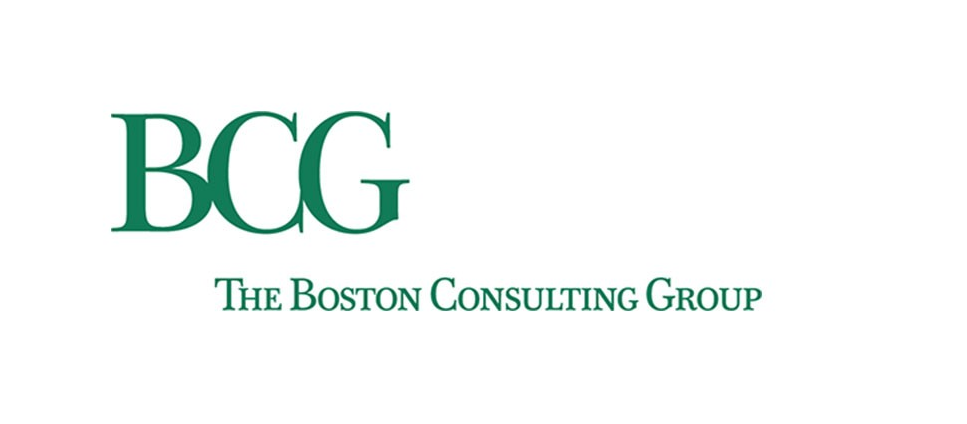

# CHURN PREDICTION

DESCRIPTION

Scenario:
Our client, PowerCo, is a major utility company providing gas and electricity to corporate,
SME and residential customers. In recent years, post-liberalization of the energy market in
Europe, PowerCo has had a growing problem with increasing customer defections above
industry average. Thus PowerCo has asked BCG to work alongside them to identify the
drivers of this problem and to devise and implement a strategy to counter it. The churn issue
is most acute in the SME division and thus they want it to be the first priority.
The head of the SME division has asked whether it is possible to predict the customers which
are most likely to churn so that they can trial a range of pre-emptive actions. He has a
hypothesis that clients are switching to cheaper providers so the first action to be trialed will
be to offer customers with high propensity of churning a 20% discount.

We have scheduled a meeting in one week's time with the head of the SME division in which
you will present our findings of the churn issue and your recommendations on how to
address it.
You are in charge of building the model and of suggesting which commercial actions should
be taken as a result of the model's outcome.
The first stage is to establish the viability of such a model. For training your model you are
provided with a dataset which includes features of SME customers in January 2016 as well as
the information about whether or not they have churned by March 2016. In addition to that
you have received the prices from 2015 for these customers. Of particular interest for the
client is how you frame the problem for training.
Given that this is the first time the client is resorting to predictive modelling, it is beneficial
to leverage descriptive statistics and visualisation for extracting interesting insights from the
provided data before diving into the model. Also while it is not mandatory, you are
encouraged to test multiple algorithms. If you do so it will helpful to describe the tested
algorithms in a simple manner.
Using the trained model you shall “score” customers in the verification data set (provided in
the eponymous file) and put them in descending order of the propensity to churn. You
should also classify these customers into two classes: those which you predict to churn are
to be labelled "1" and the remaining customers should be labelled "0" in the result template.
You will submit this file with your presentation and your predictions will be scored with area
under the ROC curve and Brier score which you shall be discussed during your presentation
session.
Finally, the client would like to have a view on whether the 20% discount offer to customers
predicted to be churned is a good measure. Given that it is a steep discount bringing their
price lower than all competitors we can assume for now that everyone who is offered will
accept it. According to regulations they cannot raise the price of someone within a year if
they accept the discount. Therefore offering it excessively is going to hit revenues hard.

Table 1 describes all the data fields which are found in the data. You will notice that the
contents of some fields are meaningless text strings. This is due to "hashing" of text fields for
data privacy. While their commercial interpretation is lost as a result of the hashing, they
may still have predictive power.

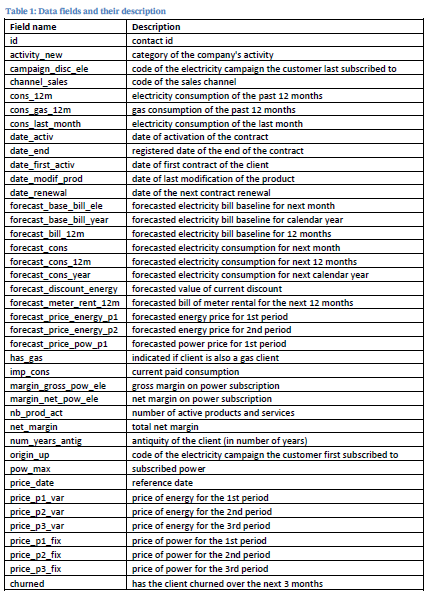

SOLUTION INPLEMENTATION

In [1]:
from plotly.offline import init_notebook_mode, iplot
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import math
%matplotlib inline
plt.style.use('ggplot')
import plotly.plotly as py
from plotly import tools
import plotly.graph_objs as go
from sklearn import preprocessing
import lightgbm as lgb
init_notebook_mode(connected=True)

### Load the data

In [2]:
path="Z:/GOOGLE DRIVE/BOOKSVSMATERIALS/MATERIALS/TRAININGS/INTERVIEWS/BCG- Boston Consulting Group/ml_case_data"
train = pd.read_csv(path+"/ml_case_training_data.csv" )
train_output =pd.read_csv(path+"/ml_case_training_output.csv" )
test=pd.read_csv(path+"/ml_case_test_data.csv" )
train_hist=pd.read_csv(path+"/ml_case_training_hist_data.csv")
test_hist=pd.read_csv(path+"/ml_case_test_hist_data.csv" )

Add target flag to the train file

In [3]:
train = pd.merge(train,train_output, how='left', on=['id'])

### Data exploration

In [4]:
print ("Train size:",train.shape)
print ("Train Output size:",train_output.shape)
print ("Test  size:",test.shape)
print ("Train_hist size:",train_hist.shape)
print ("Test_hist size:",test_hist.shape)

Train size: (16096, 33)
Train Output size: (16096, 2)
Test  size: (4024, 32)
Train_hist size: (193002, 8)
Test_hist size: (48236, 8)


Check the columns structure in the data set

In [5]:
print(train.columns)
print(test.columns)

Index(['id', 'activity_new', 'campaign_disc_ele', 'channel_sales', 'cons_12m',
       'cons_gas_12m', 'cons_last_month', 'date_activ', 'date_end',
       'date_first_activ', 'date_modif_prod', 'date_renewal',
       'forecast_base_bill_ele', 'forecast_base_bill_year',
       'forecast_bill_12m', 'forecast_cons', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_p1',
       'forecast_price_energy_p2', 'forecast_price_pow_p1', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn'],
      dtype='object')
Index(['id', 'activity_new', 'campaign_disc_ele', 'channel_sales', 'cons_12m',
       'cons_gas_12m', 'cons_last_month', 'date_activ', 'date_end',
       'date_first_activ', 'date_modif_prod', 'date_renewal',
       'forecast_base_bill_ele', 'forecast_base_bill_year',
       'forecast_bill_12m', 'f

Prepare all necessary functions for visualization

In [6]:
def missing_value_count(df):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            rate = df[col].isnull().sum() * 100 / df.shape[0]
            print(f'Column {col} has {rate:.4f}% missing values.')
        if df[col].dtype == 'object':
            if (df[col] == 'not available in demo dataset').sum() > 0:
                rate = (df[col] == 'not available in demo dataset').sum() * 100 / df.shape[0]
                print(f'Column {col} has {rate:.4f}% values not available in dataset.')
                
def categorical_univariate(variable_name):
    train[variable_name].value_counts().plot(kind='bar', label=variable_name)
    plt.legend()
    plt.title(variable_name+' distribution')                
                

def categorical_raw_figures(variable_name):
    print (train[variable_name].value_counts())
            
def split_by_churn(variable_name1,variable_name2):
    _, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
    sns.countplot(x=variable_name1, hue='churn', data=train, ax=axes[0]);
    sns.countplot(x=variable_name2, hue='churn', data=train, ax=axes[1]);     

In [7]:
def bar_hor(df, col, title, color, w=None, h=None, lm=0, limit=100, return_trace=False, rev=False, xlb = False):
    cnt_srs = df[col].value_counts()
    yy = cnt_srs.head(limit).index[::-1] 
    xx = cnt_srs.head(limit).values[::-1] 
    if rev:
        yy = cnt_srs.tail(limit).index[::-1] 
        xx = cnt_srs.tail(limit).values[::-1] 
    if xlb:
        trace = go.Bar(y=xlb, x=xx, orientation = 'h', marker=dict(color=color))
    else:
        trace = go.Bar(y=yy, x=xx, orientation = 'h', marker=dict(color=color))
    if return_trace:
        return trace 
    layout = dict(title=title, margin=dict(l=lm), width=w, height=h)
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

def bar_hor_noagg(x, y, title, color, w=None, h=None, lm=0, limit=100, rt=False):
    trace = go.Bar(y=x, x=y, orientation = 'h', marker=dict(color=color))
    if rt:
        return trace
    layout = dict(title=title, margin=dict(l=lm), width=w, height=h)
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)


def bar_ver_noagg(x, y, title, color, w=None, h=None, lm=0, rt = False):
    trace = go.Bar(y=y, x=x, marker=dict(color=color))
    if rt:
        return trace
    layout = dict(title=title, margin=dict(l=lm), width=w, height=h)
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
def gp(col, title):
    df1 = train[train["churn"] == 1]
    df0 = train[train["churn"] == 0]
    a1 = df1[col].value_counts()
    b1 = df0[col].value_counts()
    
    total = dict(train[col].value_counts())
    x0 = a1.index
    x1 = b1.index
    
    y0 = [float(x)*100 / total[x0[i]] for i,x in enumerate(a1.values)]
    y1 = [float(x)*100 / total[x1[i]] for i,x in enumerate(b1.values)]

    trace1 = go.Bar(x=a1.index, y=y0, name='churn : 1', marker=dict(color="#96D38C"))
    trace2 = go.Bar(x=b1.index, y=y1, name='churn : 0', marker=dict(color="#FEBFB3"))
    return trace1, trace2 

#### Missing values count

In [8]:
missing_value_count(train)

Column activity_new has 59.3004% missing values.
Column campaign_disc_ele has 100.0000% missing values.
Column channel_sales has 26.2053% missing values.
Column date_end has 0.0124% missing values.
Column date_first_activ has 78.2058% missing values.
Column date_modif_prod has 0.9754% missing values.
Column date_renewal has 0.2485% missing values.
Column forecast_base_bill_ele has 78.2058% missing values.
Column forecast_base_bill_year has 78.2058% missing values.
Column forecast_bill_12m has 78.2058% missing values.
Column forecast_cons has 78.2058% missing values.
Column forecast_discount_energy has 0.7828% missing values.
Column forecast_price_energy_p1 has 0.7828% missing values.
Column forecast_price_energy_p2 has 0.7828% missing values.
Column forecast_price_pow_p1 has 0.7828% missing values.
Column margin_gross_pow_ele has 0.0808% missing values.
Column margin_net_pow_ele has 0.0808% missing values.
Column net_margin has 0.0932% missing values.
Column origin_up has 0.5405% missi

In [9]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

Text(0.5,0,'Columns')

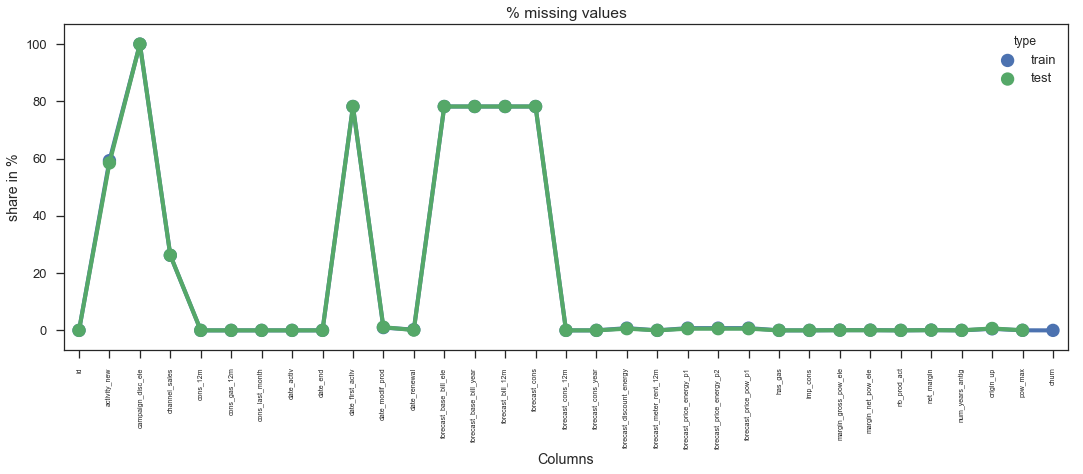

In [10]:
plt.style.use('seaborn-talk')
fig = plt.figure(figsize=(18,6))
miss_train = pd.DataFrame((train.isnull().sum())*100/train.shape[0]).reset_index()
miss_test  = pd.DataFrame((test.isnull().sum())*100/test.shape[0]).reset_index()
miss_train["type"] = "train"
miss_test["type"]  =  "test"
missing = pd.concat([miss_train,miss_test],axis=0)
ax = sns.pointplot("index",0,data=missing,hue="type")
plt.xticks(rotation =90,fontsize =7)
plt.title("% missing values")
plt.ylabel("share in %")
plt.xlabel("Columns")

In [11]:
def plot_missing_values(df,typedf):
    plt.style.use('seaborn-talk')
    fig = plt.figure(figsize=(18,6))
    miss = pd.DataFrame((df.isnull().sum())*100/df.shape[0]).reset_index()
    miss["type"] = typedf
    missing = miss
    ax = sns.pointplot("index",0,data=missing,hue="type")
    plt.xticks(rotation =90,fontsize =7)
    plt.title("% missing values")
    plt.ylabel("share in %")
    plt.xlabel("Columns")

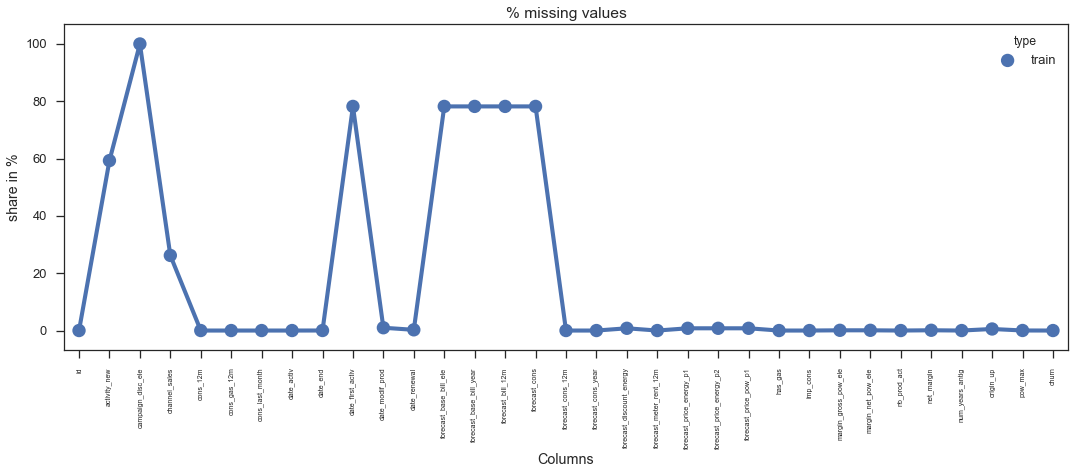

In [12]:
plot_missing_values(train,"train")

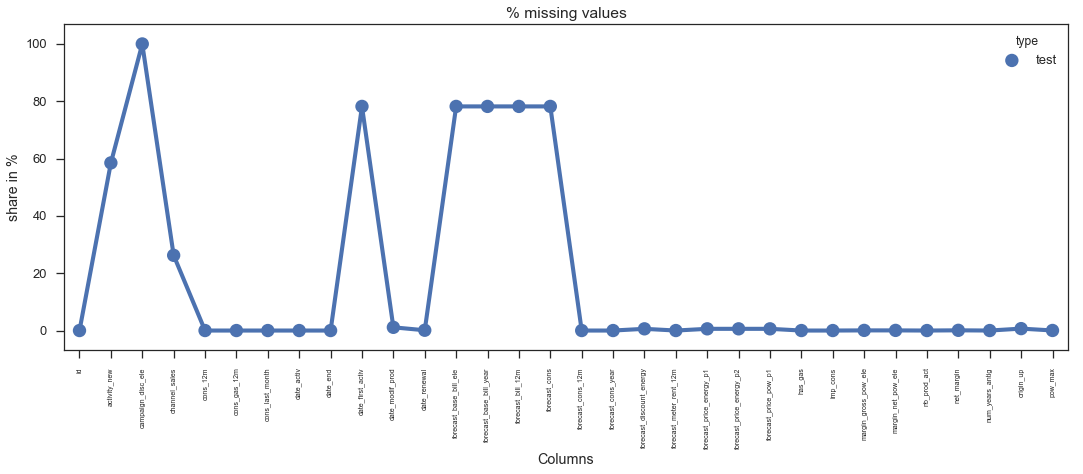

In [13]:
plot_missing_values(test,"test")

In [14]:
missing_value_count(test)

Column activity_new has 58.4990% missing values.
Column campaign_disc_ele has 100.0000% missing values.
Column channel_sales has 26.2425% missing values.
Column date_first_activ has 78.2058% missing values.
Column date_modif_prod has 1.1183% missing values.
Column date_renewal has 0.0994% missing values.
Column forecast_base_bill_ele has 78.2058% missing values.
Column forecast_base_bill_year has 78.2058% missing values.
Column forecast_bill_12m has 78.2058% missing values.
Column forecast_cons has 78.2058% missing values.
Column forecast_discount_energy has 0.5964% missing values.
Column forecast_price_energy_p1 has 0.5964% missing values.
Column forecast_price_energy_p2 has 0.5964% missing values.
Column forecast_price_pow_p1 has 0.5964% missing values.
Column margin_gross_pow_ele has 0.0497% missing values.
Column margin_net_pow_ele has 0.0497% missing values.
Column net_margin has 0.0746% missing values.
Column origin_up has 0.6710% missing values.
Column pow_max has 0.0249% missin

#### Check the structure of the table

In [15]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16096 entries, 0 to 16095
Data columns (total 33 columns):
id                          16096 non-null object
activity_new                6551 non-null object
campaign_disc_ele           0 non-null float64
channel_sales               11878 non-null object
cons_12m                    16096 non-null int64
cons_gas_12m                16096 non-null int64
cons_last_month             16096 non-null int64
date_activ                  16096 non-null object
date_end                    16094 non-null object
date_first_activ            3508 non-null object
date_modif_prod             15939 non-null object
date_renewal                16056 non-null object
forecast_base_bill_ele      3508 non-null float64
forecast_base_bill_year     3508 non-null float64
forecast_bill_12m           3508 non-null float64
forecast_cons               3508 non-null float64
forecast_cons_12m           16096 non-null float64
forecast_cons_year          16096 non-null int64

Mark different types of features

In [16]:
cat_features=['activity_new','campaign_disc_ele','channel_sales','has_gas','origin_up','nb_prod_act']
cat_features_for_label_encoding=['activity_new','campaign_disc_ele','channel_sales','has_gas','origin_up']
dates=['date_activ','date_end','date_first_activ','date_modif_prod','date_modif_prod','date_renewal']
num_features=['cons_gas_12m','cons_12m','cons_last_month','forecast_base_bill_ele','forecast_base_bill_year','forecast_bill_12m' ,'forecast_cons','forecast_cons_12m','forecast_cons_year','forecast_discount_energy','forecast_meter_rent_12m','forecast_price_energy_p1','forecast_price_energy_p2','forecast_price_pow_p1','imp_cons','margin_gross_pow_ele','margin_net_pow_ele','net_margin' ,'num_years_antig' ,'pow_max']
no_use=['']

In [17]:
train.describe()

,campaign_disc_ele,cons_12m,cons_gas_12m,cons_last_month,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,...,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn
count,0.0,1.609600e+04,1.609600e+04,1.609600e+04,3508.000000,3508.000000,3508.000000,3508.000000,16096.000000,16096.000000,...,15970.000000,15970.000000,16096.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000,16096.000000
mean,NaN,1.948044e+05,3.191164e+04,1.946154e+04,335.843857,335.843857,3837.441866,206.845165,2370.555949,1907.347229,...,0.052951,43.533496,196.123447,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093
std,NaN,6.795151e+05,1.775885e+05,8.235676e+04,649.406000,649.406000,5425.744327,455.634288,4035.085664,5257.364759,...,0.048617,5.212252,494.366979,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421,0.298796
min,NaN,-1.252760e+05,-3.037000e+03,-9.138600e+04,-364.940000,-364.940000,-2503.480000,0.000000,-16689.260000,-85627.000000,...,0.000000,-0.122184,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000
25%,NaN,5.906250e+03,0.000000e+00,0.000000e+00,0.000000,0.000000,1158.175000,0.000000,513.230000,0.000000,...,0.000000,40.606701,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000
50%,NaN,1.533250e+04,0.000000e+00,9.010000e+02,162.955000,162.955000,2187.230000,42.215000,1179.160000,378.000000,...,0.086163,44.311378,44.465000,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000
75%,NaN,5.022150e+04,0.000000e+00,4.127000e+03,396.185000,396.185000,4246.555000,228.117500,2692.077500,1994.250000,...,0.098837,44.311378,218.090000,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000
max,NaN,1.609711e+07,4.188440e+06,4.538720e+06,12566.080000,12566.080000,81122.630000,9682.890000,103801.930000,175375.000000,...,0.195975,59.444710,15042.790000,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000,1.000000


In [18]:
test.describe()

,campaign_disc_ele,cons_12m,cons_gas_12m,cons_last_month,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,...,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max
count,0.0,4.024000e+03,4.024000e+03,4024.000000,877.000000,877.000000,877.000000,877.000000,4024.000000,4024.000000,...,4000.000000,4000.000000,4000.000000,4024.000000,4022.000000,4022.000000,4024.000000,4021.000000,4024.000000,4023.000000
mean,NaN,1.956067e+05,3.215430e+04,19822.853877,378.955906,378.955906,4189.351220,243.373398,2371.909550,1931.878728,...,0.136200,0.052644,43.583727,199.620917,22.529639,20.924219,1.350149,214.573793,4.995775,20.474889
std,NaN,6.591712e+05,1.807878e+05,74651.653691,966.384967,966.384967,6684.774402,800.449450,4097.195065,5127.423458,...,0.026422,0.048472,5.017096,512.456266,24.456094,32.261943,1.449767,310.641735,1.686233,22.080230
min,NaN,-8.017800e+04,-4.275000e+03,-21618.000000,0.000000,0.000000,0.000000,-2.090000,-7478.860000,-21618.000000,...,0.000000,0.000000,0.000000,-2614.570000,-528.640000,-981.560000,1.000000,-2944.550000,2.000000,0.000000
25%,NaN,5.535750e+03,0.000000e+00,0.000000,0.000000,0.000000,1175.170000,0.000000,495.440000,0.000000,...,0.115237,0.000000,40.606701,0.000000,12.035000,11.950000,1.000000,49.930000,4.000000,12.500000
50%,NaN,1.535000e+04,0.000000e+00,951.500000,161.110000,161.110000,2289.550000,37.240000,1169.165000,382.000000,...,0.142881,0.085803,44.311378,46.340000,21.090000,21.055000,1.000000,118.580000,5.000000,13.856000
75%,NaN,5.110175e+04,0.000000e+00,4100.250000,422.590000,422.590000,4411.460000,234.550000,2725.870000,2112.250000,...,0.146348,0.098837,44.311378,228.965000,28.800000,28.760000,1.000000,281.610000,6.000000,19.919000
max,NaN,6.286272e+06,2.813019e+06,771203.000000,19021.240000,19021.240000,78364.770000,18267.500000,89289.070000,170022.000000,...,0.273963,0.168092,59.266378,18267.500000,500.320000,500.320000,32.000000,4255.900000,13.000000,408.000000


In [19]:
train_hist.describe()

,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
count,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000
mean,0.140991,0.054412,0.030712,43.325546,10.698201,6.455436
std,0.025117,0.050033,0.036335,5.437952,12.856046,7.782279
min,0.000000,0.000000,0.000000,-0.177779,-0.097752,-0.065172
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101780,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


In [20]:
test_hist.describe()

,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
count,47934.000000,47934.000000,47934.000000,47934.000000,47934.000000,47934.000000
mean,0.141101,0.054113,0.030695,43.363630,10.702320,6.468525
std,0.025095,0.049888,0.036281,5.265513,12.845396,7.787556
min,0.000000,0.000000,0.000000,-0.162916,-0.097752,-0.065172
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085408,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.169597,0.101037,59.444710,36.490689,17.458221


#### Variables not in test but in train

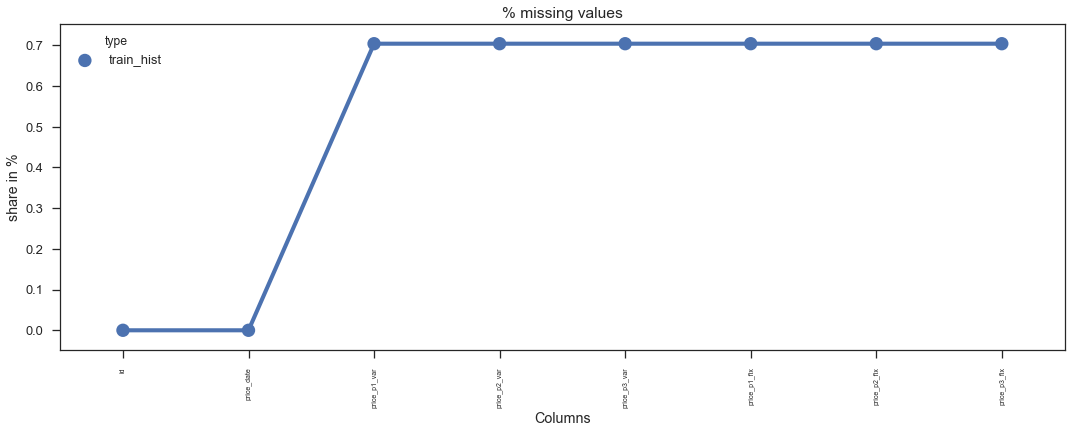

In [21]:
plot_missing_values(train_hist,"train_hist")

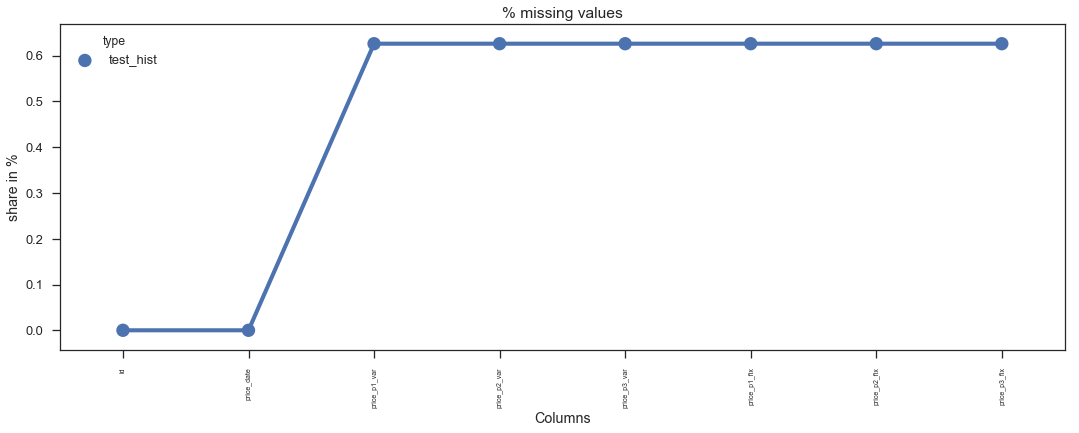

In [22]:
plot_missing_values(test_hist,"test_hist")

Label encoding of categorical features for better representation as some of the variables are hashed currently

In [23]:
# label encode the categorical variables and convert the numerical variables to float
cat_cols = cat_features
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()    
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

activity_new
campaign_disc_ele
channel_sales
has_gas
origin_up
nb_prod_act


In [24]:
print("Variables not in test but in train: ", set(train.columns).difference(set(test.columns)))

Variables not in test but in train:  {'churn'}


In [25]:
tr0 = bar_hor(train, "churn", "Distribution of churn Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1, tr2 = gp('churn', 'Distribution of churn with churn')

fig = tools.make_subplots(rows=1, cols=3, print_grid=False, subplot_titles = ["churn" , "churn, churn=1" ,"churn, churn=0"])
fig.append_trace(tr0, 1, 1);
fig.append_trace(tr1, 1, 2);
fig.append_trace(tr2, 1, 3);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=50));
iplot(fig);

In [26]:
tr0 = bar_hor(train, "channel_sales", "Distribution of channel_sales Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1, tr2 = gp('channel_sales', 'Distribution of churn with channel_sales')

fig = tools.make_subplots(rows=1, cols=3, print_grid=False, subplot_titles = ["channel_sales" , "channel_sales, churn=1" ,"channel_sales, churn=0"])
fig.append_trace(tr0, 1, 1);
fig.append_trace(tr1, 1, 2);
fig.append_trace(tr2, 1, 3);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=50));
iplot(fig);

In [27]:
tr0 = bar_hor(train, "origin_up", "Distribution of origin_up Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1, tr2 = gp('origin_up', 'Distribution of churn with origin_up')

fig = tools.make_subplots(rows=1, cols=3, print_grid=False, subplot_titles = ["origin_up" , "origin_up, churn=1" ,"origin_up, churn=0"])
fig.append_trace(tr0, 1, 1);
fig.append_trace(tr1, 1, 2);
fig.append_trace(tr2, 1, 3);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=50));
iplot(fig);

In [28]:
tr0 = bar_hor(train, "has_gas", "Distribution of has_gas Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1, tr2 = gp('has_gas', 'Distribution of churn with channel_sales')

fig = tools.make_subplots(rows=1, cols=3, print_grid=False, subplot_titles = ["has_gas" , "has_gas, churn=1" ,"has_gas, churn=0"])
fig.append_trace(tr0, 1, 1);
fig.append_trace(tr1, 1, 2);
fig.append_trace(tr2, 1, 3);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=50));
iplot(fig);

In [29]:
tr0 = bar_hor(train, "nb_prod_act", "Distribution of nb_prod_act Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1, tr2 = gp('nb_prod_act', 'Distribution of churn with channel_sales')

fig = tools.make_subplots(rows=1, cols=3, print_grid=False, subplot_titles = ["nb_prod_act" , "nb_prod_act, churn=1" ,"nb_prod_act, churn=0"])
fig.append_trace(tr0, 1, 1);
fig.append_trace(tr1, 1, 2);
fig.append_trace(tr2, 1, 3);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=50));
iplot(fig);

In [30]:
tr0 = bar_hor(train, "forecast_discount_energy", "Distribution of forecast_discount_energy Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1, tr2 = gp('forecast_discount_energy', 'Distribution of churn with forecast_discount_energy')

fig = tools.make_subplots(rows=1, cols=3, print_grid=False, subplot_titles = ["forecast_discount_energy" , "forecast_discount_energy, churn=1" ,"forecast_discount_energy, churn=0"])
fig.append_trace(tr0, 1, 1);
fig.append_trace(tr1, 1, 2);
fig.append_trace(tr2, 1, 3);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=50));
iplot(fig);

In [31]:
categorical_raw_figures('churn')
print("-----------------------------")
categorical_raw_figures('channel_sales')
print("-----------------------------")
categorical_raw_figures('origin_up')
print("-----------------------------")
categorical_raw_figures('has_gas')
print("-----------------------------")
categorical_raw_figures('nb_prod_act')
print("-----------------------------")
categorical_raw_figures('activity_new')
print("-----------------------------")
categorical_raw_figures('forecast_discount_energy')

0    14501
1     1595
Name: churn, dtype: int64
-----------------------------
3    7377
5    4218
4    2073
7    1444
1     966
6      12
0       4
2       2
Name: channel_sales, dtype: int64
-----------------------------
4    7825
2    4517
3    3664
5      87
6       2
1       1
Name: origin_up, dtype: int64
-----------------------------
0    13132
1     2964
Name: has_gas, dtype: int64
-----------------------------
0     12560
2      2708
3       561
6       170
7        37
5        25
10       12
8         9
9         8
4         4
1         2
Name: nb_prod_act, dtype: int64
-----------------------------
290    9545
18     1577
212     422
234     230
154     219
70      189
84      122
74      119
416     119
353      83
352      75
365      72
188      64
345      62
107      61
90       58
173      57
63       51
186      50
55       48
53       48
285      44
361      43
30       43
98       41
248      41
334      41
223      36
28       34
68       33
       ... 
101       1


In [32]:
churn_rate= train[train.churn==1].id.count()/train.churn.count()  
print("Churn rate on train=",churn_rate*100,"%")

Churn rate on train= 9.90929423459 %


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16096 entries, 0 to 16095
Data columns (total 33 columns):
id                          16096 non-null object
activity_new                16096 non-null int64
campaign_disc_ele           16096 non-null int64
channel_sales               16096 non-null int64
cons_12m                    16096 non-null int64
cons_gas_12m                16096 non-null int64
cons_last_month             16096 non-null int64
date_activ                  16096 non-null object
date_end                    16094 non-null object
date_first_activ            3508 non-null object
date_modif_prod             15939 non-null object
date_renewal                16056 non-null object
forecast_base_bill_ele      3508 non-null float64
forecast_base_bill_year     3508 non-null float64
forecast_bill_12m           3508 non-null float64
forecast_cons               3508 non-null float64
forecast_cons_12m           16096 non-null float64
forecast_cons_year          16096 non-null int6

In [34]:
def continuous_distribs(a,b):
    fig, ax =plt.subplots(1,2,figsize=(15,5))
    sns.distplot(a.isna()==False, ax=ax[0])
    sns.distplot(b.isna()==False, ax=ax[1])
    fig.show()  
    
def continuous_distribs_bins(a,b,bins):
    fig, ax =plt.subplots(1,2,figsize=(15,5))
    sns.distplot(a.isna()==False,bins=bins,ax=ax[0])
    sns.distplot(b.isna()==False,bins=bins,ax=ax[1])
    fig.show()   
  
def kde_by_churn(var_name,title):
    plt.figure(figsize=(12,5))
    # KDE займов, выплаченных вовремя
    sns.kdeplot(train.loc[train['churn'] == 0, var_name], label = 'churn == 0')
    # KDE проблемных займов
    sns.kdeplot(train.loc[train['churn'] == 1, var_name], label = 'churn == 1')
    # Обозначения
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title(title);
    
def kde_by_churn1(var_name,title):
    
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    
    ##sns.set_style("whitegrid")
    
    plt.figure(figsize=(12,5))
    trainc=train[train.isna()==False]
    # KDE займов, выплаченных вовремя
    sns.kdeplot(trainc.loc[train['churn'] == 0, var_name], label = 'churn == 0')
    # KDE проблемных займов
    sns.kdeplot(trainc.loc[train['churn'] == 1, var_name], label = 'churn == 1')
    # Обозначения
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title(title);
    
    
def kde_by_churn2(var_name,title,train):
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    
    ##sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white '})
    plt.figure(figsize=(12,5))
    # KDE займов, выплаченных вовремя
    sns.kdeplot(train.loc[train['churn'] == 0, var_name], label = 'churn == 0')
    # KDE проблемных займов
    sns.kdeplot(train.loc[train['churn'] == 1, var_name], label = 'churn == 1')
    # Обозначения
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title(title) 

C:\Users\Verano\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning:

invalid value encountered in greater

C:\Users\Verano\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning:

invalid value encountered in less



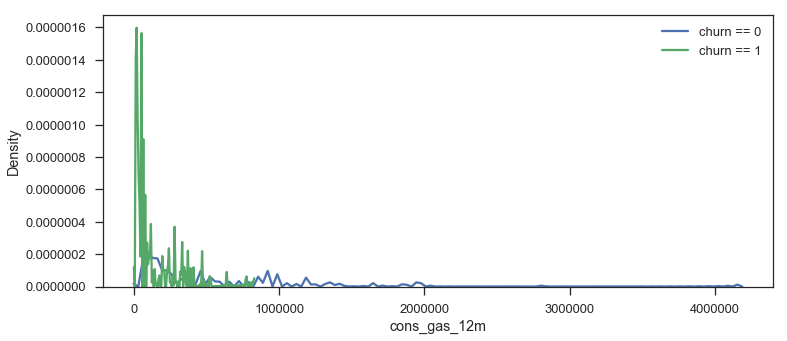

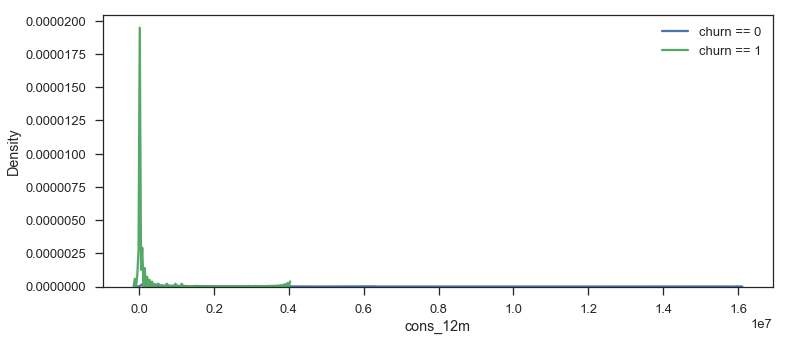

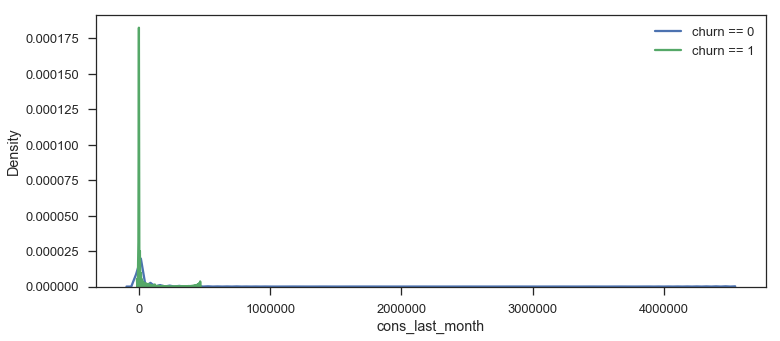

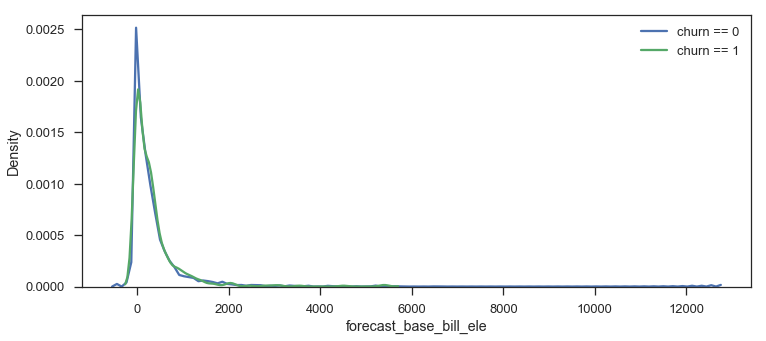

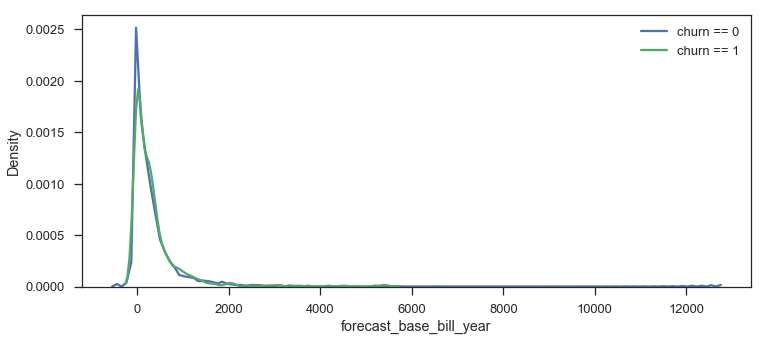

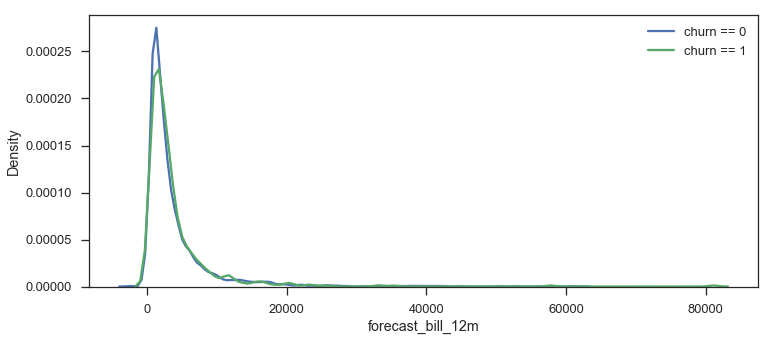

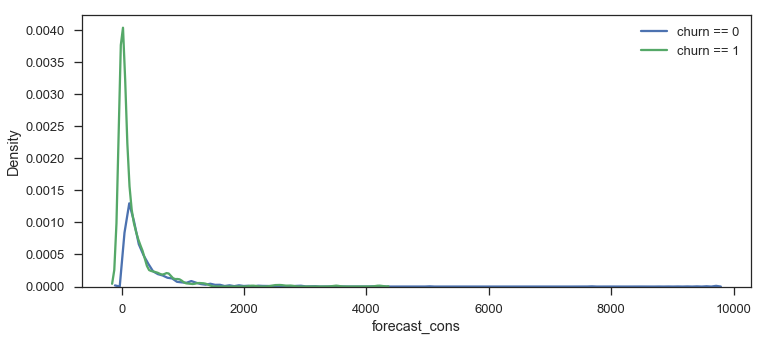

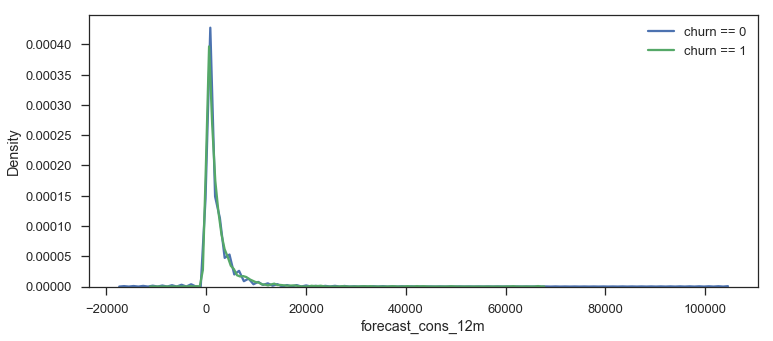

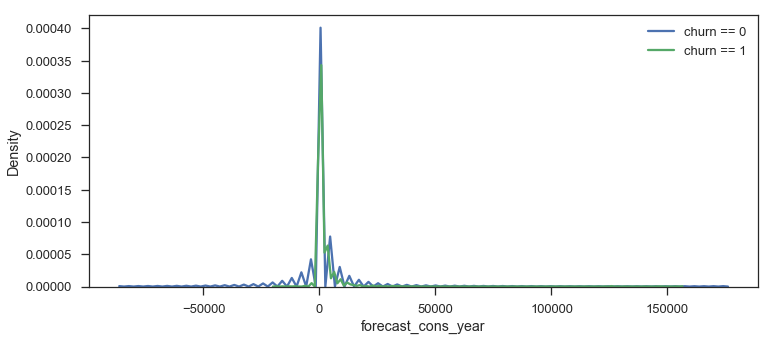

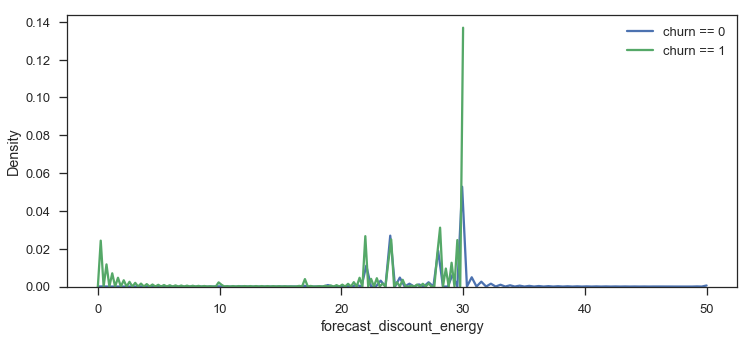

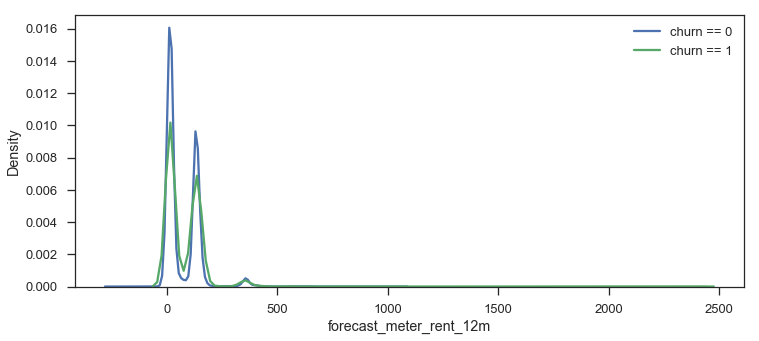

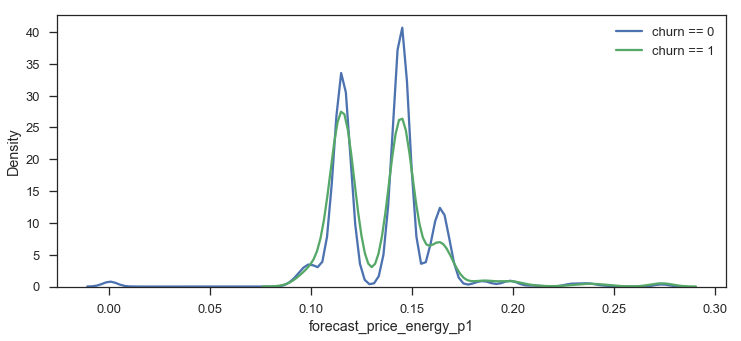

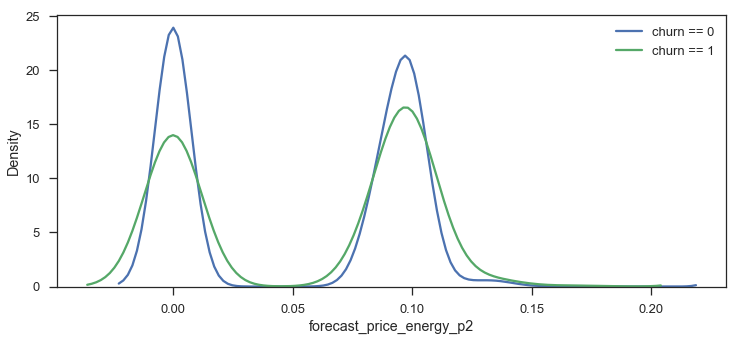

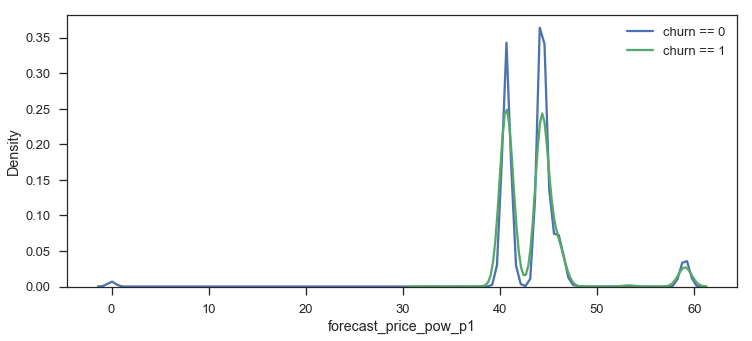

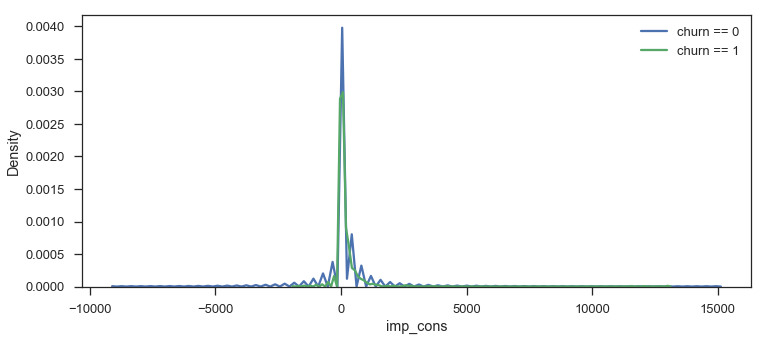

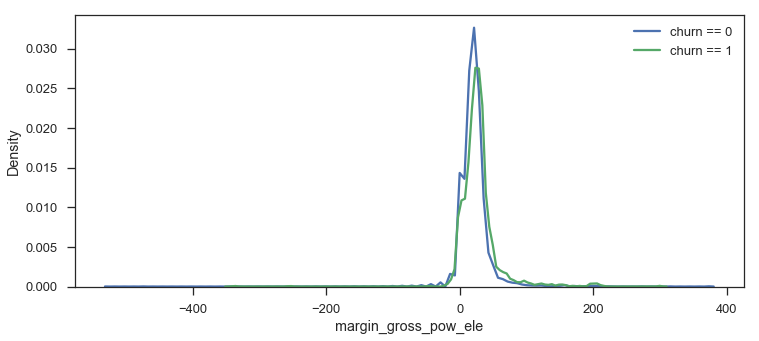

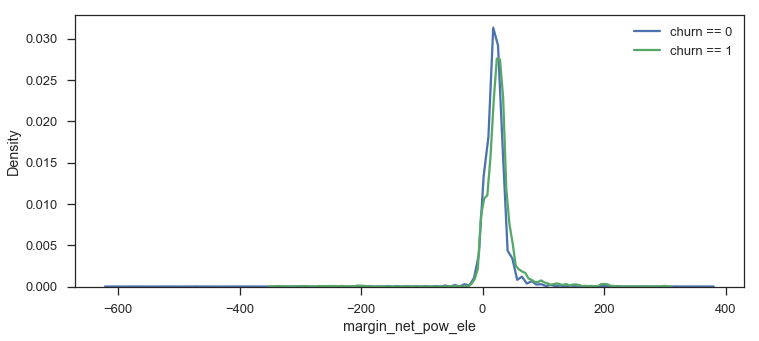

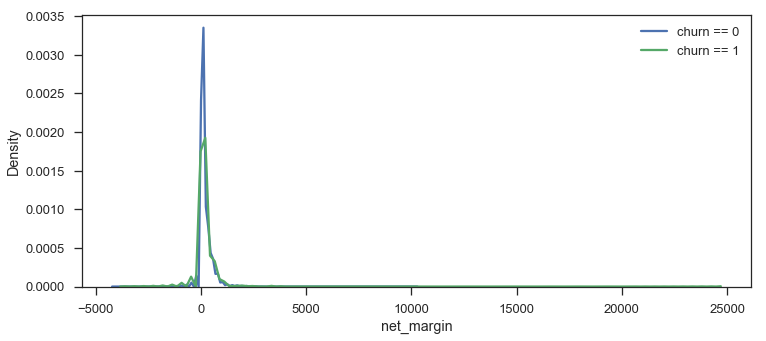

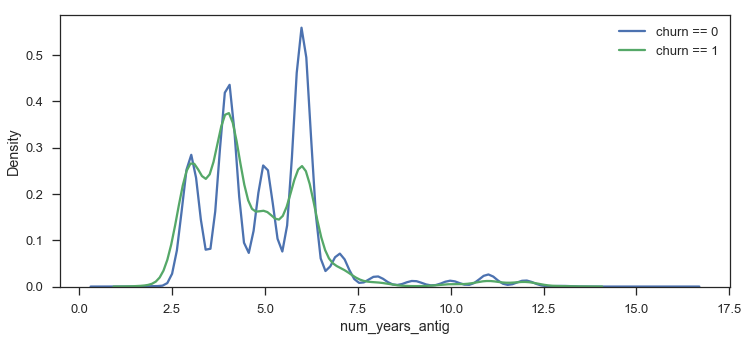

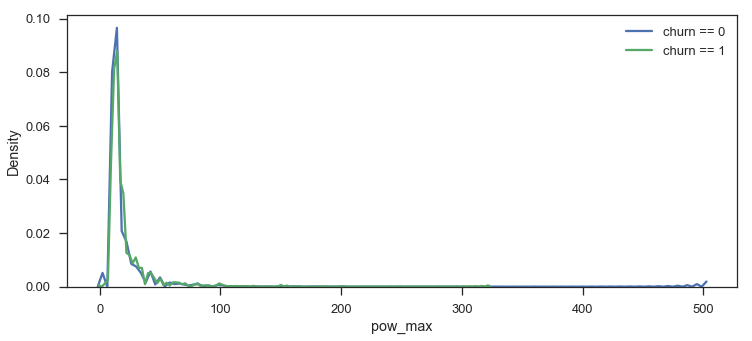

In [35]:
num_features=['cons_gas_12m','cons_12m','cons_last_month','forecast_base_bill_ele','forecast_base_bill_year','forecast_bill_12m' ,'forecast_cons','forecast_cons_12m','forecast_cons_year','forecast_discount_energy','forecast_meter_rent_12m','forecast_price_energy_p1','forecast_price_energy_p2','forecast_price_pow_p1','imp_cons','margin_gross_pow_ele','margin_net_pow_ele','net_margin' ,'num_years_antig' ,'pow_max']
for elem in num_features:
    kde_by_churn(elem,'')

C:\Users\Verano\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning:

invalid value encountered in greater

C:\Users\Verano\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning:

invalid value encountered in less



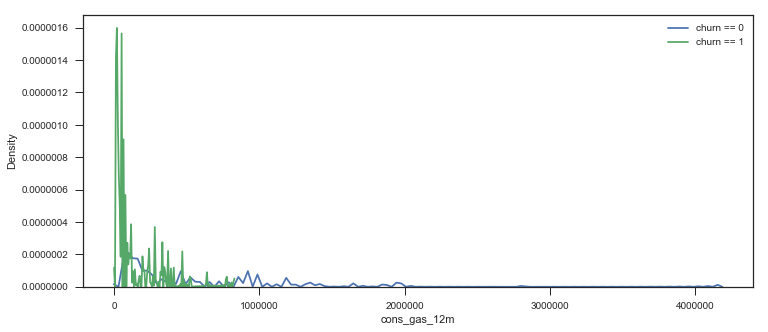

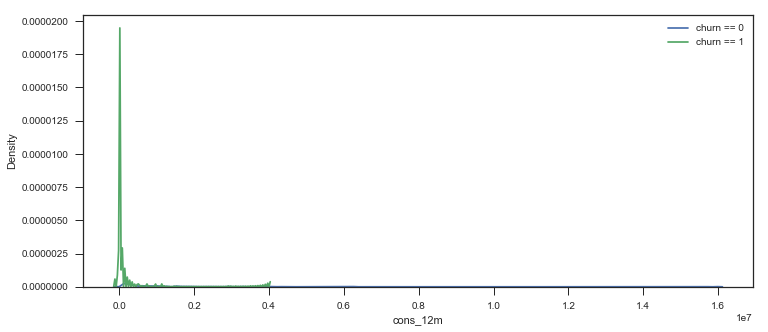

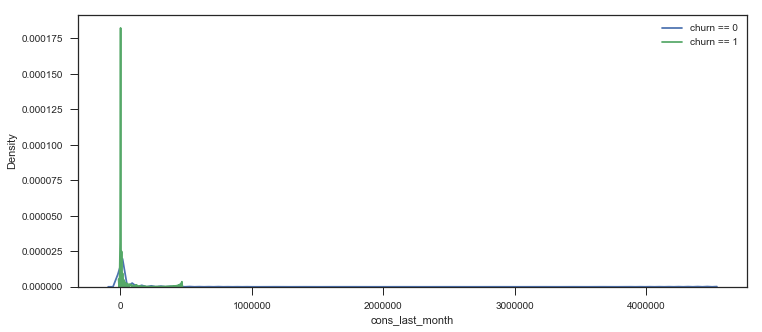

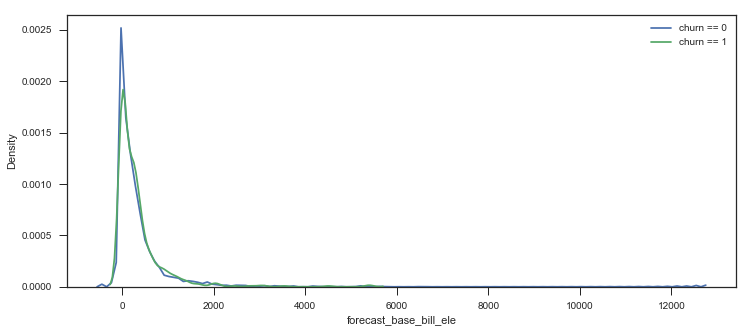

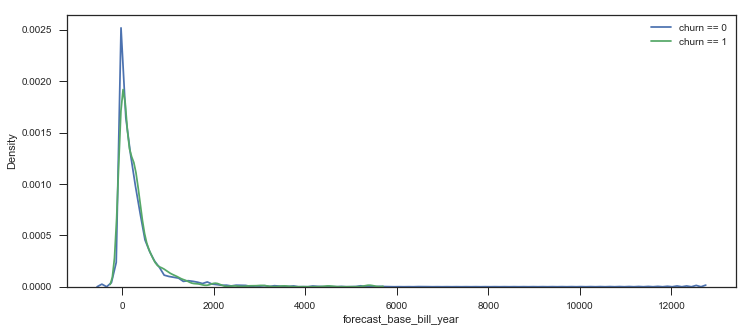

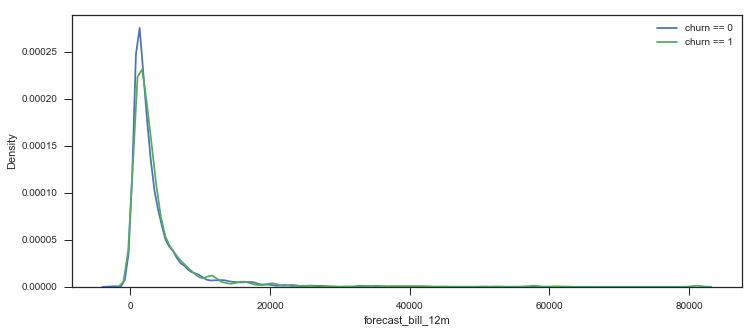

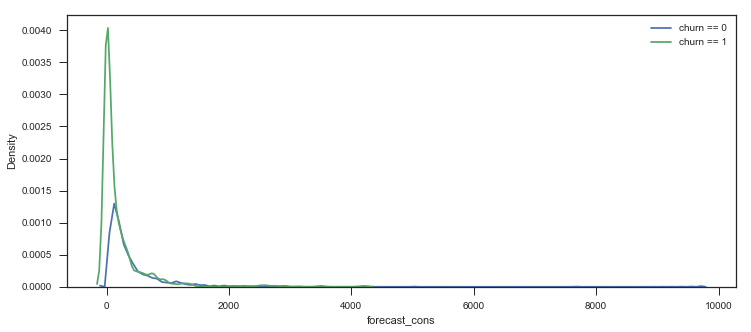

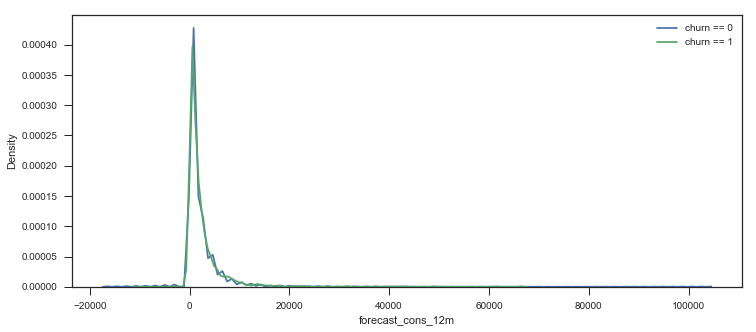

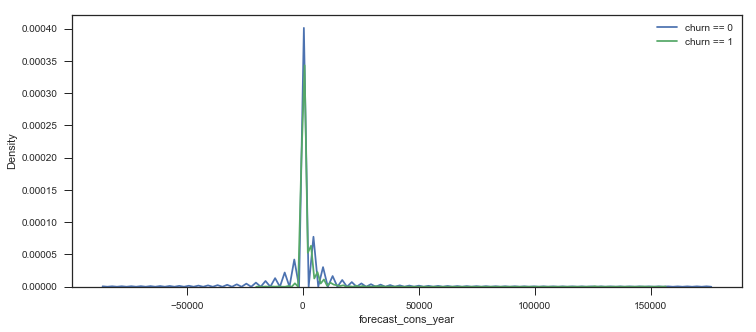

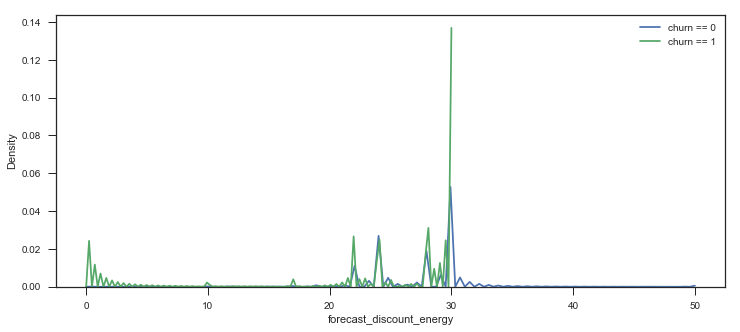

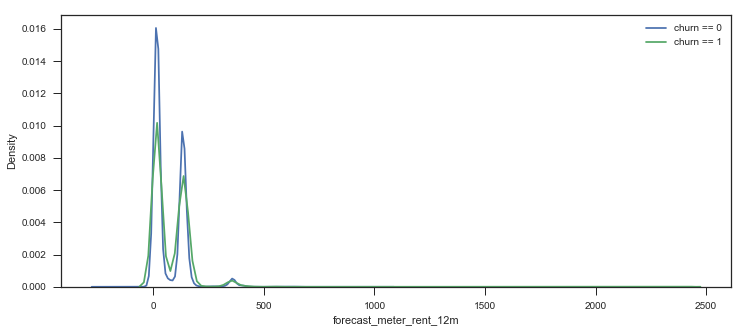

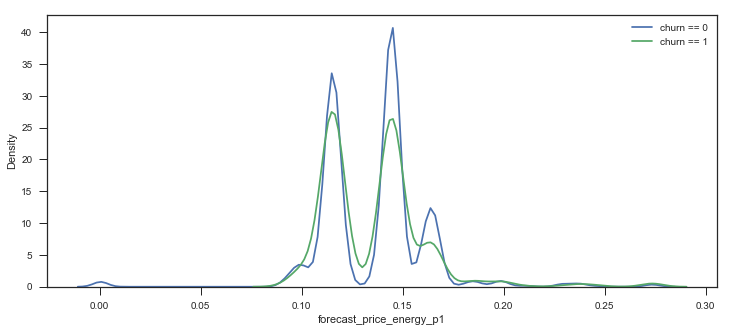

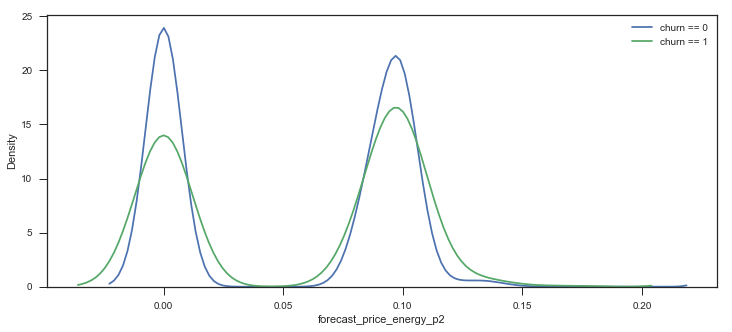

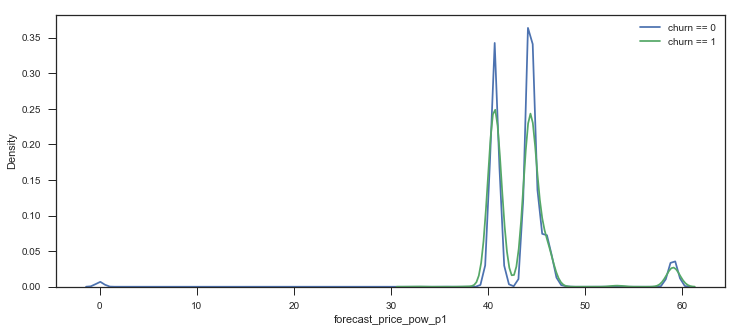

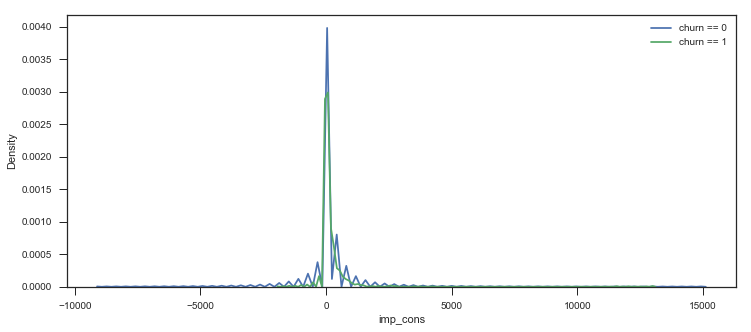

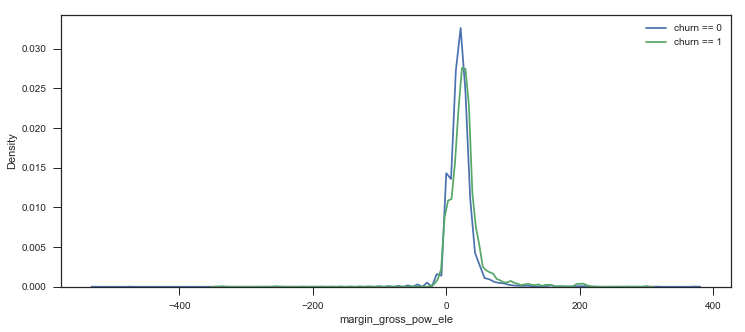

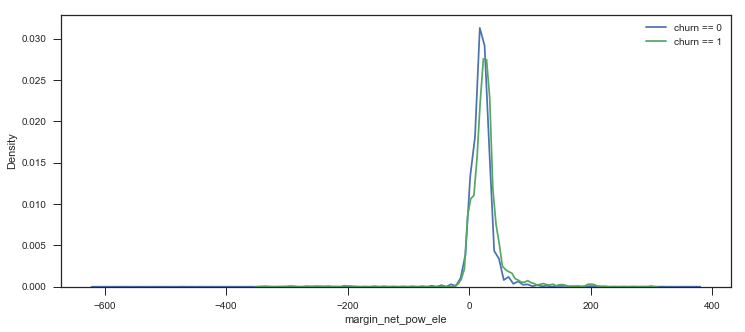

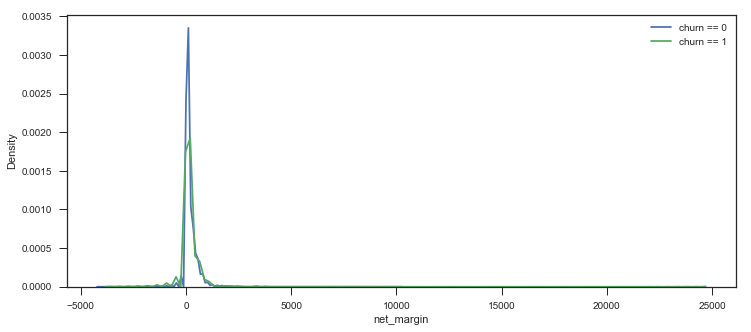

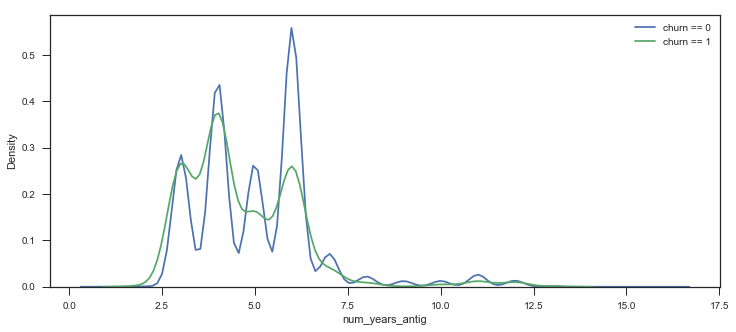

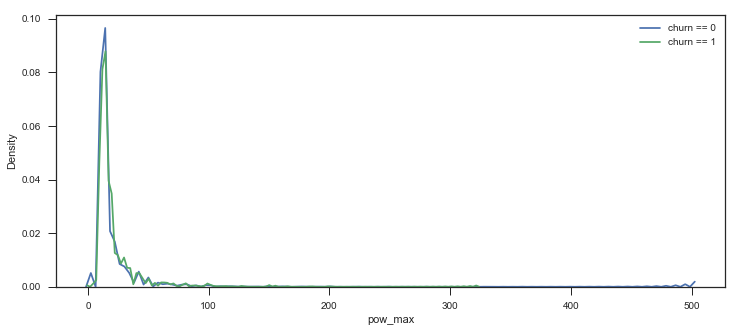

In [36]:
for elem in num_features:
    kde_by_churn1(elem,'')


Take into account that a lot of missing values were repaced to 0.
Make an analysis and think what could be the best option to replace missing values

In [37]:
corr_matrix = train.drop(['churn'], axis=1).corr()

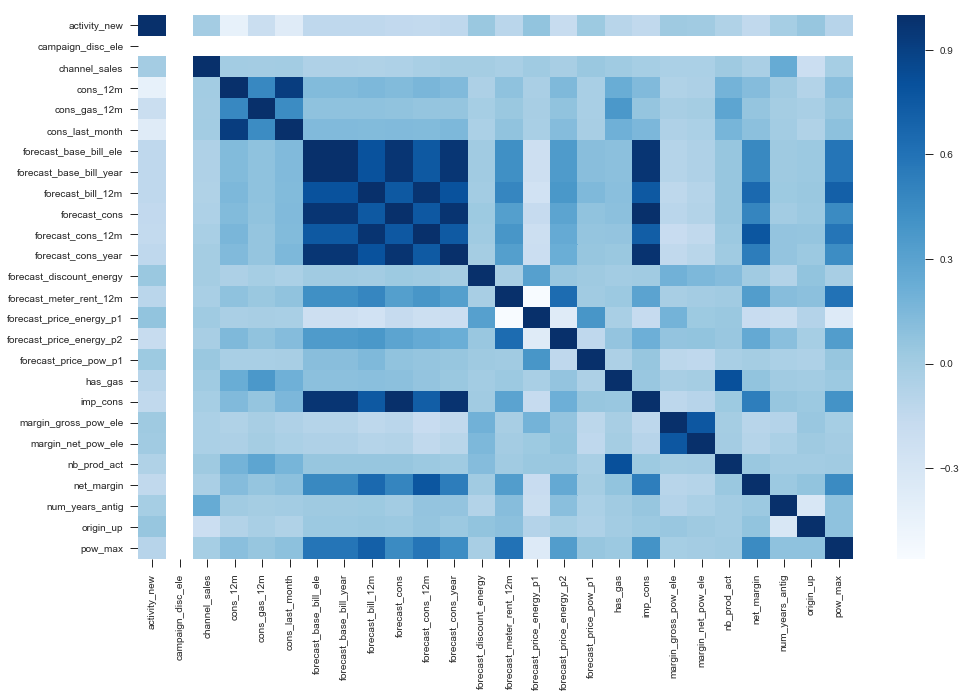

In [38]:
plt.figure(figsize = (16,10))
sns_heatmap=sns.heatmap(corr_matrix,cmap="Blues");

In [39]:
correlations = train.corr()['churn'].sort_values()
# Отображение
print('The highest positive correlation: \n', correlations.tail(15))
print('\nThe highest negative correlation: \n', correlations.head(15))

The highest positive correlation: 
 imp_cons                    0.003417
forecast_price_pow_p1       0.004034
forecast_bill_12m           0.006909
forecast_cons_12m           0.007395
pow_max                     0.009456
forecast_discount_energy    0.012344
forecast_price_energy_p2    0.025597
net_margin                  0.029308
forecast_meter_rent_12m     0.029971
activity_new                0.031486
margin_net_pow_ele          0.063187
margin_gross_pow_ele        0.080158
origin_up                   0.098807
churn                       1.000000
campaign_disc_ele                NaN
Name: churn, dtype: float64

The highest negative correlation: 
 num_years_antig            -0.071565
cons_12m                   -0.051759
cons_last_month            -0.046931
cons_gas_12m               -0.040880
channel_sales              -0.032198
has_gas                    -0.032033
nb_prod_act                -0.024386
forecast_cons              -0.005247
forecast_price_energy_p1   -0.003337
forecast_ba

In [40]:
##g = sns.pairplot(train, hue='churn')

In [41]:
## There is no block with PRICES HISTORY DATA

### GENERATE FEATURES

### Generate features from dates

In [42]:
def differ_days(date1, date2):
    a = date1
    b = date2
    return (a-b).days

In [43]:
train['current_date']='2016-12-31'
train['current_date']= pd.to_datetime(train['current_date'])

train['date_activ']= pd.to_datetime(train.date_activ)
train['date_end']= pd.to_datetime(train.date_end)
train['date_first_activ']= pd.to_datetime(train.date_first_activ)
train['date_modif_prod']= pd.to_datetime(train.date_modif_prod)
train['date_renewal']= pd.to_datetime(train.date_renewal)

train['days_since_activation'] = train.apply(lambda row: differ_days(row['current_date'], row['date_activ']), axis=1)
train['days_to_contract_end']= train.apply(lambda row: differ_days(row['date_end'], row['current_date']), axis=1)
train['days_since_first_contract']= train.apply(lambda row: differ_days(row['current_date'], row['date_first_activ']), axis=1)
train['days_since_last_prod_mod']= train.apply(lambda row: differ_days(row['current_date'], row['date_modif_prod']), axis=1)
train['days_to_renewal']=train.apply(lambda row: differ_days(row['date_renewal'], row['current_date']), axis=1) 

test['current_date']='2016-12-31'
test['current_date']= pd.to_datetime(test['current_date'])

test['date_activ']= pd.to_datetime(test.date_activ)
test['date_end']= pd.to_datetime(test.date_end)
test['date_first_activ']= pd.to_datetime(test.date_first_activ)
test['date_modif_prod']= pd.to_datetime(test.date_modif_prod)
test['date_renewal']= pd.to_datetime(test.date_renewal)

test['days_since_activation'] = test.apply(lambda row: differ_days(row['current_date'], row['date_activ']), axis=1)
test['days_to_contract_end']= test.apply(lambda row: differ_days(row['date_end'], row['current_date']), axis=1)
test['days_since_first_contract']= test.apply(lambda row: differ_days(row['current_date'], row['date_first_activ']), axis=1)
test['days_since_last_prod_mod']= test.apply(lambda row: differ_days(row['current_date'], row['date_modif_prod']), axis=1)
test['days_to_renewal']=test.apply(lambda row: differ_days(row['date_renewal'], row['current_date']), axis=1)  

In [44]:
print (test.shape)
print (train.shape)

(4024, 38)
(16096, 39)


#### Create list of columns of specific types

In [45]:
cat_features=['channel_sales','has_gas','origin_up']
ordinal_data=['nb_prod_act']
dates=['date_activ','date_end','date_first_activ','date_modif_prod','date_modif_prod','date_renewal']
num_features=['cons_gas_12m','cons_12m','cons_last_month','forecast_base_bill_ele','forecast_base_bill_year','forecast_bill_12m' ,'forecast_cons','forecast_cons_12m','forecast_cons_year','forecast_discount_energy','forecast_meter_rent_12m','forecast_price_energy_p1','forecast_price_energy_p2','forecast_price_pow_p1','imp_cons','margin_gross_pow_ele','margin_net_pow_ele','net_margin' ,'num_years_antig' ,'pow_max']
no_use=['activity_new','campaign_disc_ele',]
new_features=['days_since_activation','days_to_contract_end','days_since_first_contract','days_since_last_prod_mod','days_to_renewal']
target=['churn']
missingmore50=['date_first_activ','forecast_base_bill_ele','forecast_base_bill_year','forecast_bill_12m','forecast_cons']
inf=['avg_qty1','avg_qty2','avg_qty3']

#### One hot encoding

In [46]:
categorical_features = cat_features
one_hot_df = pd.concat([train,test])
one_hot_df = pd.get_dummies(one_hot_df, columns=categorical_features)
train= one_hot_df.iloc[:train.shape[0],:]
test = one_hot_df.iloc[train.shape[0]:,]
print ('Train Sample Format', train.shape)
print ('Test Sample Format', test.shape)

Train Sample Format (16096, 53)
Test Sample Format (4024, 53)


C:\Users\Verano\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




In [47]:
print (test.shape)
print (train.shape)

(4024, 53)
(16096, 53)


In [48]:
def nont_zero_value_check(field):
    if (field==0) or field==None:
        val=0
    else:
        val=1
    return val

In [49]:
def weird_division(n, d):
    return n / d if d else 0

#### Price data manipulations

In [50]:
train_hist['sum_all_prices_var']=train_hist['price_p1_var']+train_hist['price_p2_var']+train_hist['price_p3_var']
train_hist['sum_all_prices_fix']=train_hist['price_p1_fix']+train_hist['price_p2_fix']+train_hist['price_p3_fix']

train_hist['is_empty1'] =train_hist['price_p1_var'].apply(nont_zero_value_check)
train_hist['is_empty2'] =train_hist['price_p2_var'].apply(nont_zero_value_check)
train_hist['is_empty3'] =train_hist['price_p3_var'].apply(nont_zero_value_check)

train_hist['is_empty1_fix'] =train_hist['price_p1_fix'].apply(nont_zero_value_check)
train_hist['is_empty2_fix'] =train_hist['price_p2_fix'].apply(nont_zero_value_check)
train_hist['is_empty3_fix'] =train_hist['price_p3_fix'].apply(nont_zero_value_check)
train_hist['num_not_empty']=train_hist['is_empty1']+train_hist['is_empty2']+train_hist['is_empty3']
train_hist['num_not_empty_fix']=train_hist['is_empty1_fix']+train_hist['is_empty2_fix']+train_hist['is_empty3_fix']


train_hist['average_raw_price']=train_hist['sum_all_prices_var']/train_hist['num_not_empty']
train_hist['average_raw_price_fix']=train_hist['sum_all_prices_fix']/train_hist['num_not_empty_fix']

##------

test_hist['sum_all_prices_var'] =test_hist['price_p1_var']+test_hist['price_p2_var']+test_hist['price_p3_var']
test_hist['sum_all_prices_fix'] =test_hist['price_p1_fix']+test_hist['price_p2_fix']+test_hist['price_p3_fix']

test_hist['is_empty1'] =test_hist['price_p1_var'].apply(nont_zero_value_check)
test_hist['is_empty2'] =test_hist['price_p2_var'].apply(nont_zero_value_check)
test_hist['is_empty3'] =test_hist['price_p3_var'].apply(nont_zero_value_check)
test_hist['num_not_empty']=test_hist['is_empty1']+test_hist['is_empty2']+test_hist['is_empty3']


test_hist['is_empty1_fix'] =test_hist['price_p1_fix'].apply(nont_zero_value_check)
test_hist['is_empty2_fix'] =test_hist['price_p2_fix'].apply(nont_zero_value_check)
test_hist['is_empty3_fix'] =test_hist['price_p3_fix'].apply(nont_zero_value_check)
test_hist['num_not_empty_fix']=test_hist['is_empty1_fix']+test_hist['is_empty2_fix']+test_hist['is_empty3_fix']


test_hist['average_raw_price']=test_hist['sum_all_prices_var']/test_hist['num_not_empty']
test_hist['average_raw_price_fix']=test_hist['sum_all_prices_fix']/test_hist['num_not_empty_fix']

##------
##-------

In [51]:
train_hist['p1_deviisonp1_fix']=train_hist['price_p1_fix']/train_hist['price_p1_var']
train_hist['p2_deviisonp2_fix']=train_hist['price_p2_fix']/train_hist['price_p2_var']
train_hist['p3_deviisonp3_fix']=train_hist['price_p3_fix']/train_hist['price_p3_var']

test_hist['p1_deviisonp1_fix']=test_hist['price_p1_fix']/train_hist['price_p1_var']
test_hist['p2_deviisonp2_fix']=test_hist['price_p2_fix']/train_hist['price_p2_var']
test_hist['p3_deviisonp3_fix']=test_hist['price_p3_fix']/train_hist['price_p3_var']

In [52]:
train_hist.price_p1_fix.sum()
train.pow_max.sum()

331582.27499999997

In [53]:
test.shape

(4024, 53)

#### Generate features from price data

In [54]:
def add_aggregated_features(dataframe,original):

    df= pd.DataFrame()

    df['mean_price1']=dataframe.groupby(['id'])['price_p1_var'].mean()
    df['median_price1']=dataframe.groupby(['id'])['price_p1_var'].median()
    df['min_price1']=dataframe.groupby(['id'])['price_p1_var'].min()
    df['max_price1']=dataframe.groupby(['id'])['price_p1_var'].max()
    df['num_change_price1']=dataframe.groupby(['id'])['price_p1_var'].nunique()

    df['mean_price2']=dataframe.groupby(['id'])['price_p2_var'].mean()
    df['median_price2']=dataframe.groupby(['id'])['price_p2_var'].median()
    df['min_price2']=dataframe.groupby(['id'])['price_p2_var'].min()
    df['max_price2']=dataframe.groupby(['id'])['price_p2_var'].max()
    df['num_change_price2']=dataframe.groupby(['id'])['price_p2_var'].nunique()

    df['mean_price3']=dataframe.groupby(['id'])['price_p3_var'].mean()
    df['median_price3']=dataframe.groupby(['id'])['price_p3_var'].median()
    df['min_price3']=dataframe.groupby(['id'])['price_p3_var'].min()
    df['max_price3']=dataframe.groupby(['id'])['price_p3_var'].max()
    df['num_change_price3']=dataframe.groupby(['id'])['price_p3_var'].nunique()

    df['mean_price_fix1']=dataframe.groupby(['id'])['price_p1_fix'].mean()
    df['median_price_fix1']=dataframe.groupby(['id'])['price_p1_fix'].median()
    df['min_price_fix1']=dataframe.groupby(['id'])['price_p1_fix'].min()
    df['max_price_fix1']=dataframe.groupby(['id'])['price_p1_fix'].max()
    df['num_change_pricefix1']=dataframe.groupby(['id'])['price_p1_fix'].nunique()

    df['mean_price_fix2']=dataframe.groupby(['id'])['price_p2_fix'].mean()
    df['median_price_fix2']=dataframe.groupby(['id'])['price_p2_fix'].median()
    df['min_price_fix2']=dataframe.groupby(['id'])['price_p2_fix'].min()
    df['max_price_fix2']=dataframe.groupby(['id'])['price_p2_fix'].max()
    df['num_change_pricefix2']=dataframe.groupby(['id'])['price_p2_fix'].nunique()

    df['mean_price_fix3']=dataframe.groupby(['id'])['price_p3_fix'].mean()
    df['median_price_fix_3']=dataframe.groupby(['id'])['price_p3_fix'].median()
    df['min_price_fix3']=dataframe.groupby(['id'])['price_p3_fix'].min()
    df['max_price_fix3']=dataframe.groupby(['id'])['price_p3_fix'].max()
    df['num_change_pricefix3']=dataframe.groupby(['id'])['price_p3_fix'].nunique()

    df['avg_prc']=dataframe.groupby(['id'])['average_raw_price'].mean()
    df['avg_prc_fx']=dataframe.groupby(['id'])['average_raw_price_fix'].mean()
    
    df['avg_qty1']=dataframe.groupby(['id'])['p1_deviisonp1_fix'].mean()
    df['avg_qty2']=dataframe.groupby(['id'])['p2_deviisonp2_fix'].mean()
    df['avg_qty3']=dataframe.groupby(['id'])['p3_deviisonp3_fix'].mean()
   
    original1=original.copy()
    
    return  pd.merge(original1,df,how='left', on=['id']),list(df.columns)

In [55]:
train_with_prices,train_with_prices_columns=add_aggregated_features(train_hist,train)
test_with_prices,test_with_prices_columns=add_aggregated_features(test_hist,test)

In [56]:
test_with_prices.shape

(4024, 88)

### Price and related to it  EDA

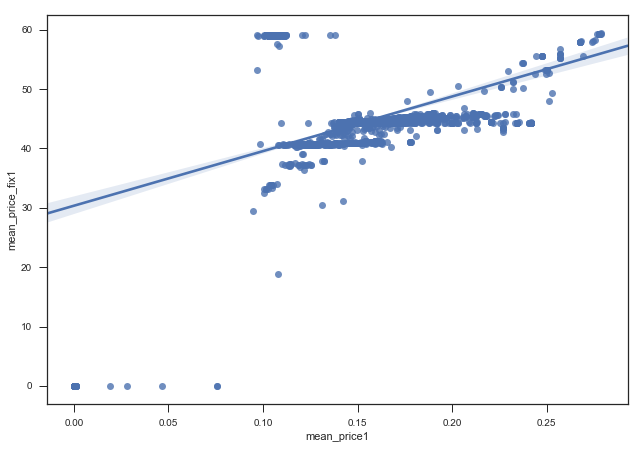

In [57]:
rg=sns.regplot(train_with_prices.mean_price1,train_with_prices.mean_price_fix1)

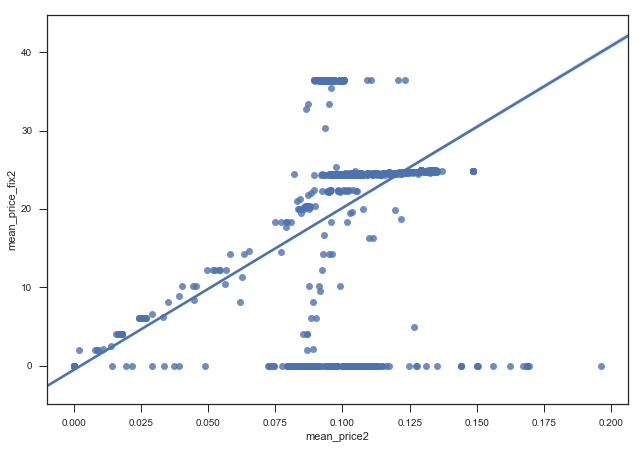

In [58]:
rg=sns.regplot(train_with_prices.mean_price2,train_with_prices.mean_price_fix2)

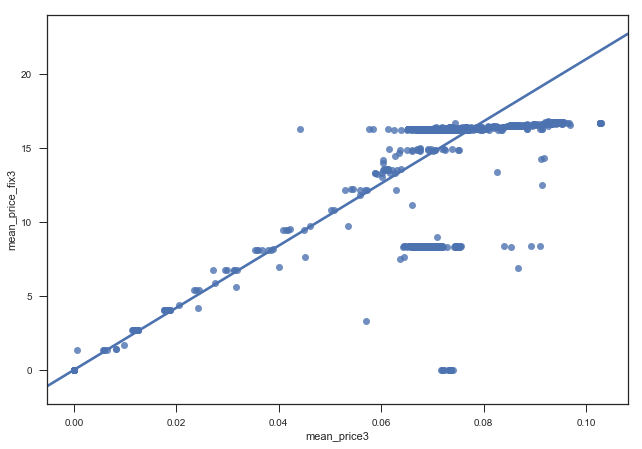

In [59]:
rg=sns.regplot(train_with_prices.mean_price3,train_with_prices.mean_price_fix3)


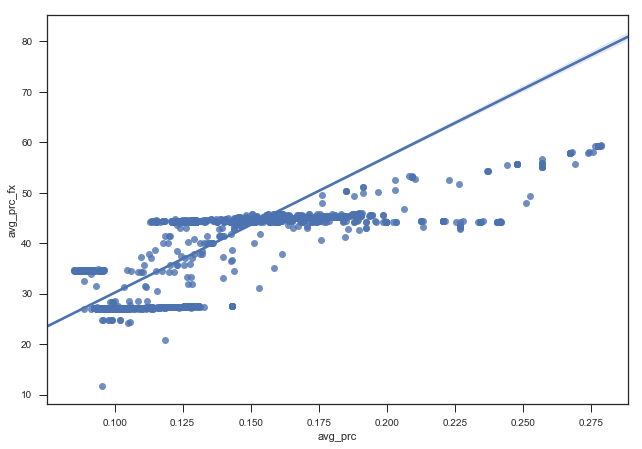

In [60]:
rg=sns.regplot(train_with_prices.avg_prc,train_with_prices.avg_prc_fx)

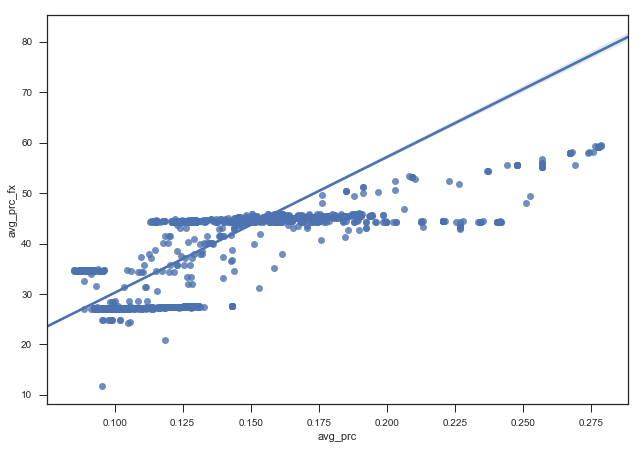

In [61]:
rg=sns.regplot(train_with_prices.avg_prc,train_with_prices.avg_prc_fx)

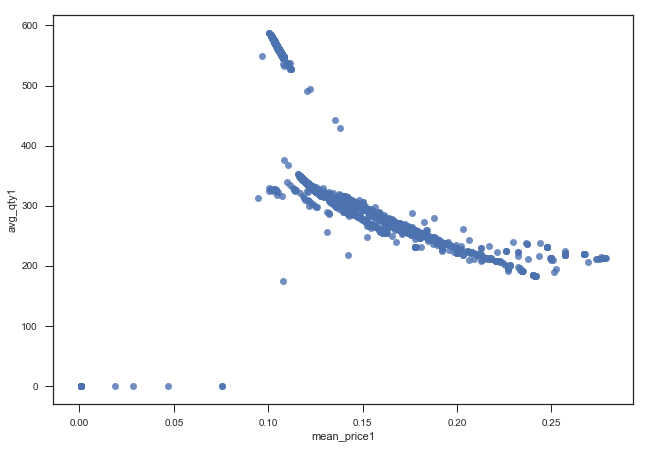

In [62]:
rg=sns.regplot(train_with_prices.mean_price1,train_with_prices.avg_qty1)

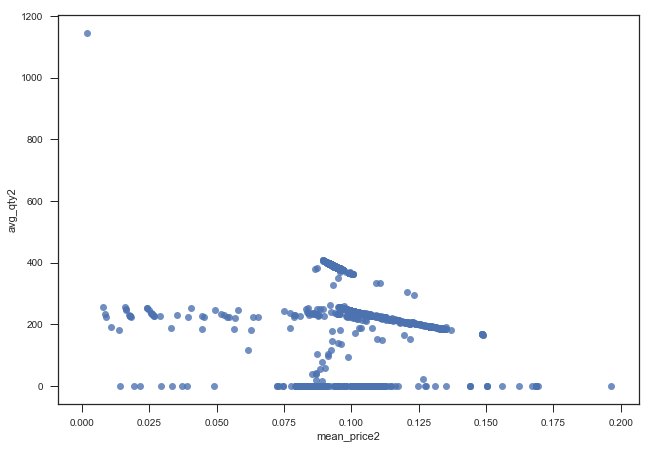

In [63]:
rg=sns.regplot(train_with_prices.mean_price2,train_with_prices.avg_qty2)

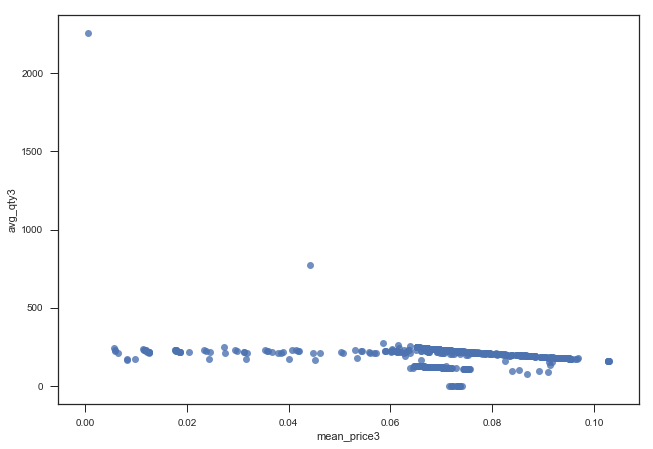

In [64]:
rg=sns.regplot(train_with_prices.mean_price3,train_with_prices.avg_qty3)

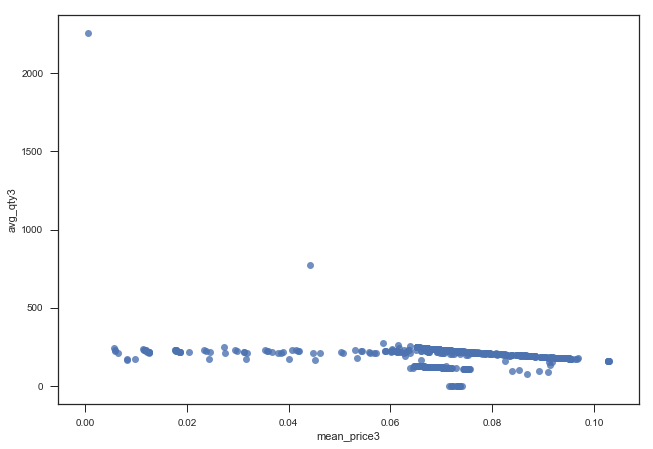

In [65]:
rg=sns.regplot(train_with_prices.mean_price3,train_with_prices.avg_qty3)

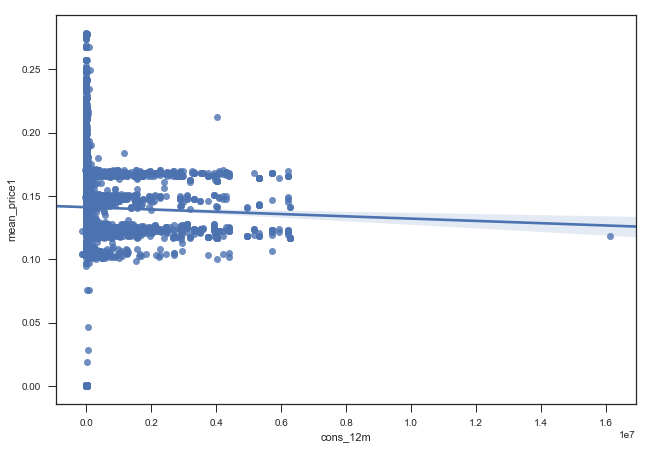

In [66]:
rg=sns.regplot(train_with_prices.cons_12m,train_with_prices.mean_price1)

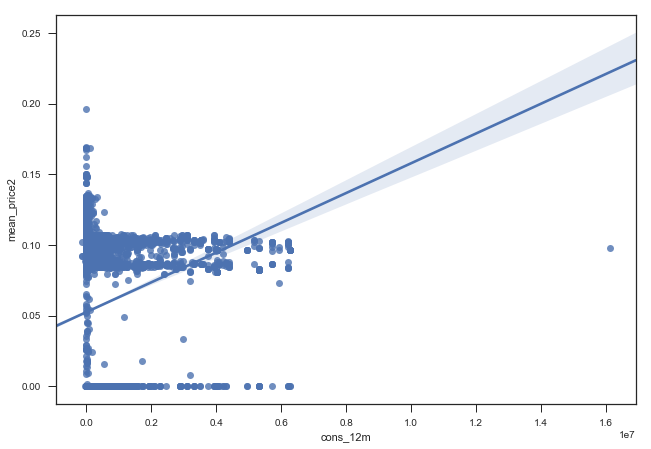

In [67]:
rg=sns.regplot(train_with_prices.cons_12m,train_with_prices.mean_price2)

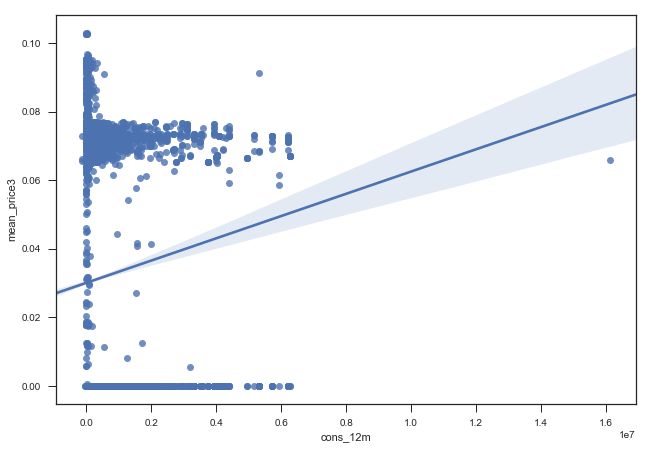

In [68]:
rg=sns.regplot(train_with_prices.cons_12m,train_with_prices.mean_price3)

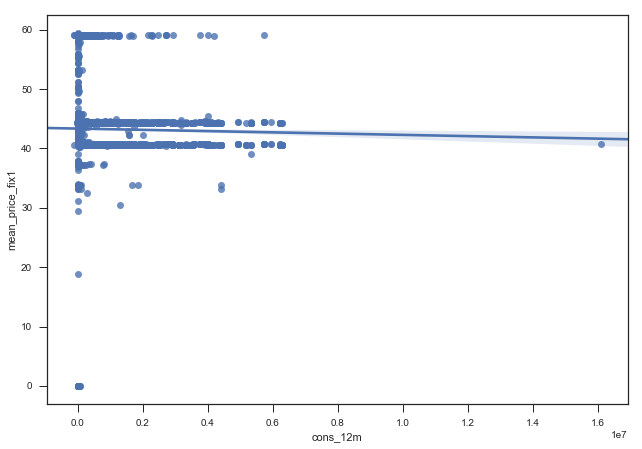

In [69]:
rg=sns.regplot(train_with_prices.cons_12m,train_with_prices.mean_price_fix1)

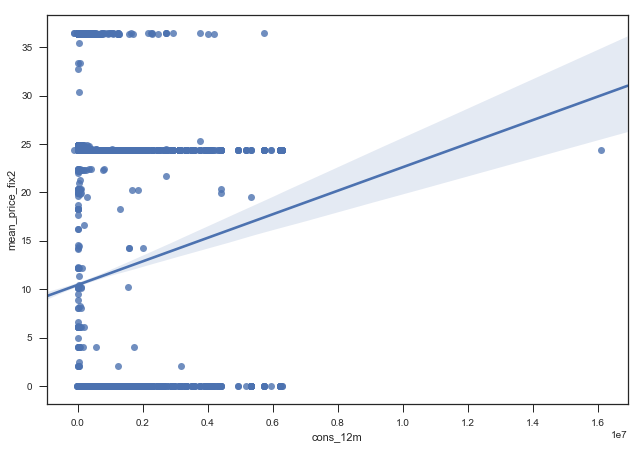

In [70]:
rg=sns.regplot(train_with_prices.cons_12m,train_with_prices.mean_price_fix2)

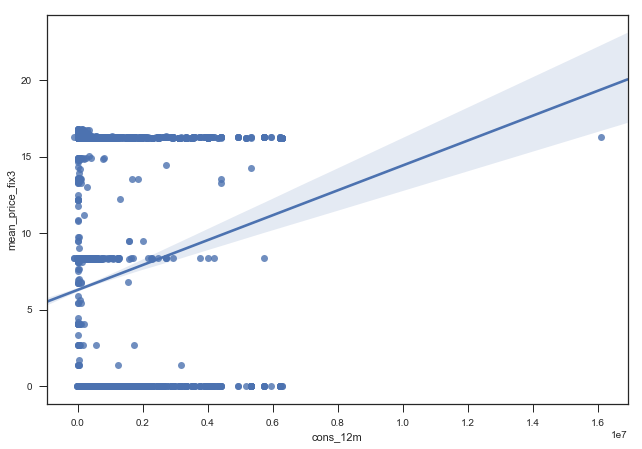

In [71]:
rg=sns.regplot(train_with_prices.cons_12m,train_with_prices.mean_price_fix3)

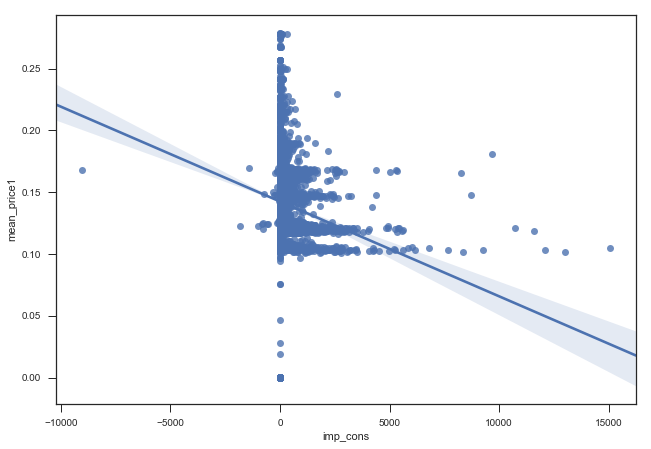

In [72]:
rg=sns.regplot(train_with_prices.imp_cons,train_with_prices.mean_price1)

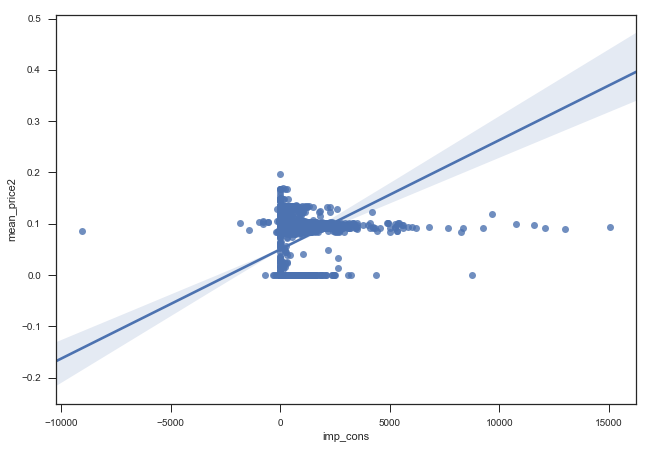

In [73]:
rg=sns.regplot(train_with_prices.imp_cons,train_with_prices.mean_price2)

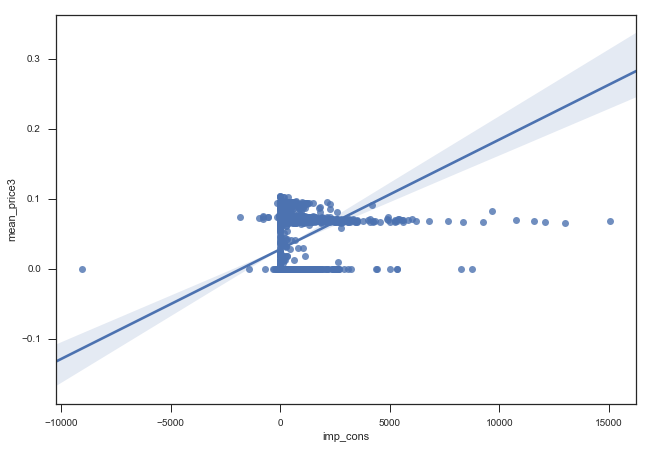

In [74]:
rg=sns.regplot(train_with_prices.imp_cons,train_with_prices.mean_price3)

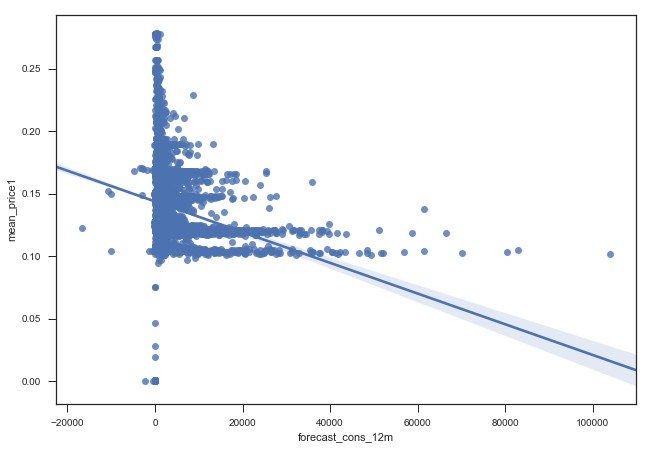

In [75]:
rg=sns.regplot(train_with_prices.forecast_cons_12m,train_with_prices.mean_price1)

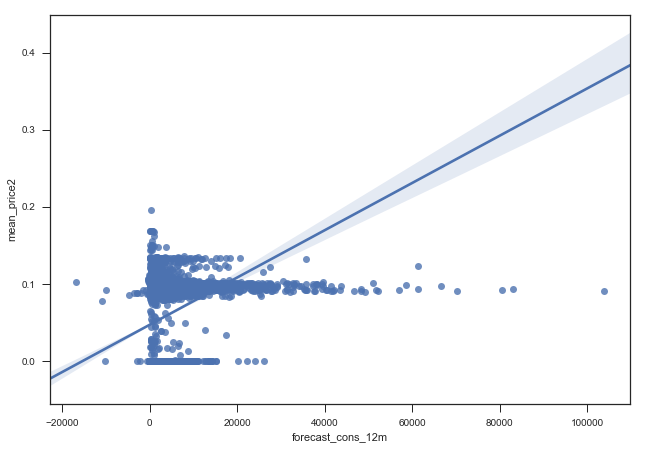

In [76]:
rg=sns.regplot(train_with_prices.forecast_cons_12m,train_with_prices.mean_price2)

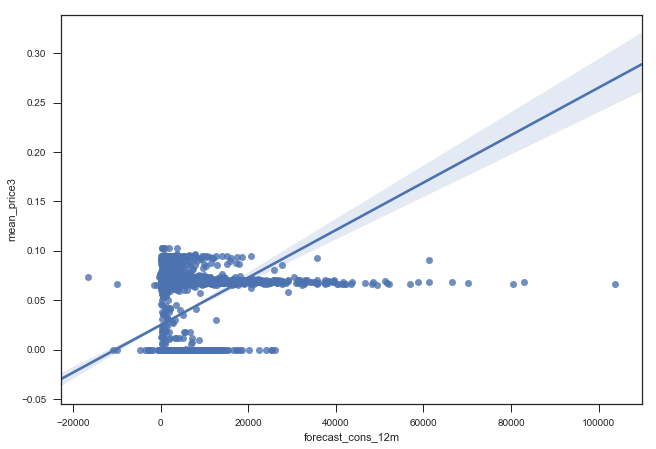

In [77]:
rg=sns.regplot(train_with_prices.forecast_cons_12m,train_with_prices.mean_price3)

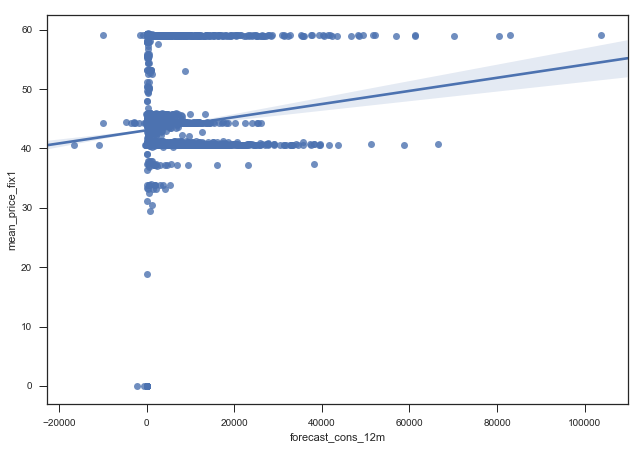

In [78]:
rg=sns.regplot(train_with_prices.forecast_cons_12m,train_with_prices.mean_price_fix1)

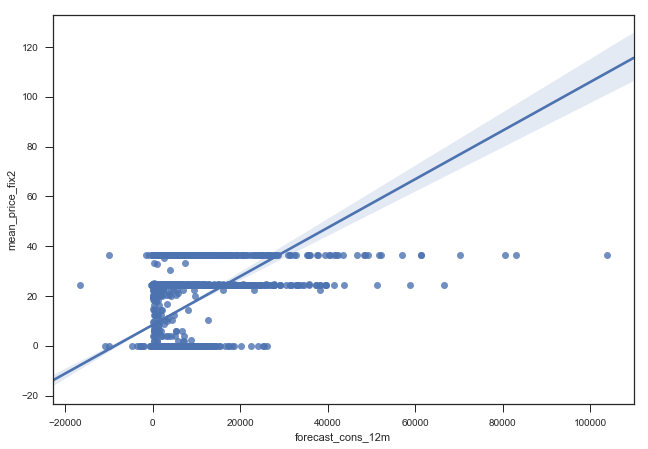

In [79]:
rg=sns.regplot(train_with_prices.forecast_cons_12m,train_with_prices.mean_price_fix2)

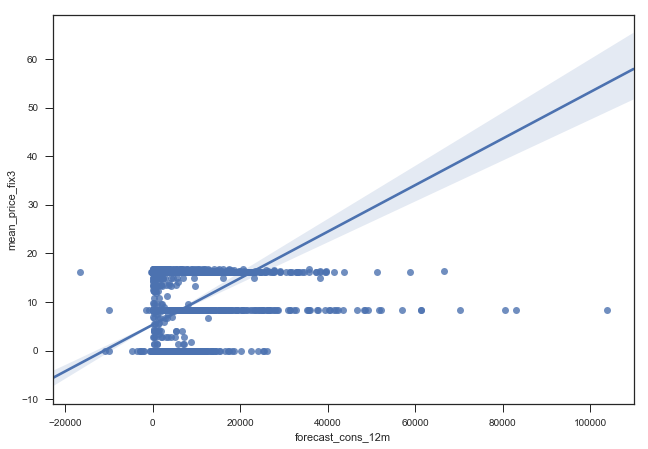

In [80]:
rg=sns.regplot(train_with_prices.forecast_cons_12m,train_with_prices.mean_price_fix3)

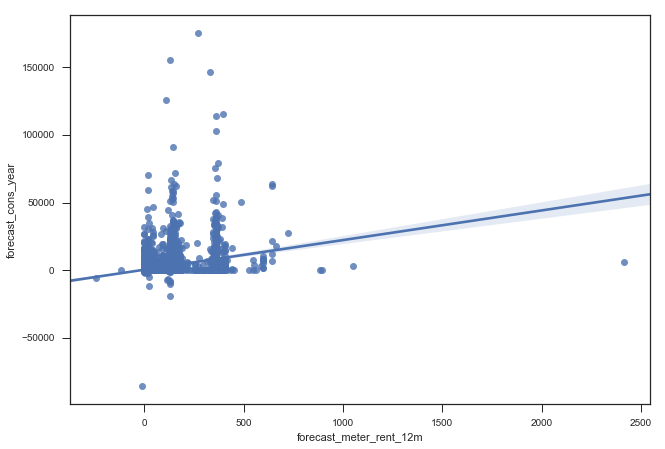

In [81]:
rg=sns.regplot(train_with_prices.forecast_meter_rent_12m,train_with_prices.forecast_cons_year)

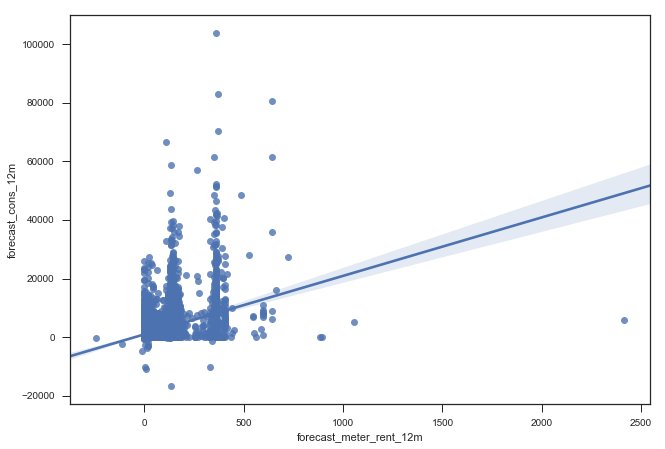

In [82]:
rg=sns.regplot(train_with_prices.forecast_meter_rent_12m,train_with_prices.forecast_cons_12m)

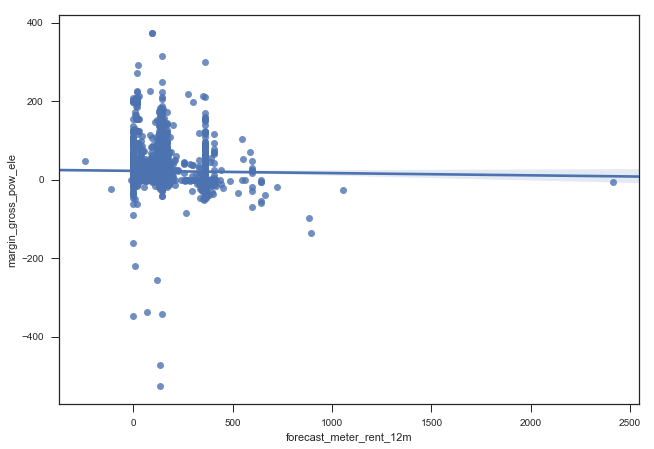

In [97]:
rg=sns.regplot(train_with_prices.forecast_meter_rent_12m,train_with_prices.margin_gross_pow_ele )

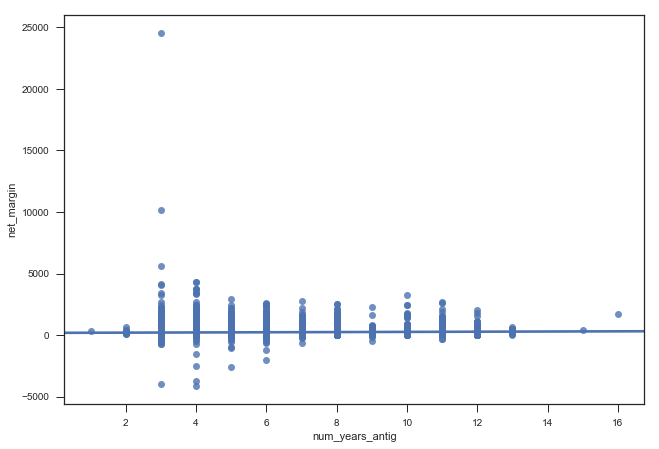

In [98]:
rg=sns.regplot(train_with_prices.num_years_antig,train_with_prices.net_margin)

In [83]:
train_hist.month=train_hist['price_date'].apply(lambda x: str(x)[3:5])

C:\Users\Verano\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



In [92]:
train.hist=train_hist.fillna(0)

In [93]:
def get_month_data(month):
    data=train_hist[train_hist.month==month]
    return data
    ##data.feature_3.plot()

In [94]:
import plotly.plotly as py
import plotly.tools as tls

import pylab as plt

def plot_interesting(var_name):
    fig = plt.figure()

    x =get_month_data("01")[var_name]
    y =get_month_data("02")[var_name]
    z =get_month_data("03")[var_name]
    a =get_month_data("04")[var_name]
    b =get_month_data("05")[var_name]
    c =get_month_data("06")[var_name]
    d =get_month_data("07")[var_name]
    e =get_month_data("08")[var_name]
    f =get_month_data("09")[var_name]
    g =get_month_data("10")[var_name]
    h =get_month_data("11")[var_name]
    j =get_month_data("12")[var_name]
    n, bins, patches = plt.hist([x,y,z,a,b,c,d,e,f,g,h,j])

    fig.set_size_inches(15, 10)
    plotly_fig = tls.mpl_to_plotly(fig)
    return py.iplot(plotly_fig, filename='mpl-multi-histogram')

In [86]:
train_hist.head()

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,sum_all_prices_var,sum_all_prices_fix,...,is_empty1_fix,is_empty2_fix,is_empty3_fix,num_not_empty,num_not_empty_fix,average_raw_price,average_raw_price_fix,p1_deviisonp1_fix,p2_deviisonp2_fix,p3_deviisonp3_fix
0,038af19179925da21a25619c5a24b745,01.01.2015,0.151367,0.0,0.0,44.266931,0.0,0.0,0.151367,44.266931,...,1,0,0,1,1,0.151367,44.266931,292.447701,NaN,NaN
1,038af19179925da21a25619c5a24b745,01.02.2015,0.151367,0.0,0.0,44.266931,0.0,0.0,0.151367,44.266931,...,1,0,0,1,1,0.151367,44.266931,292.447701,NaN,NaN
2,038af19179925da21a25619c5a24b745,01.03.2015,0.151367,0.0,0.0,44.266931,0.0,0.0,0.151367,44.266931,...,1,0,0,1,1,0.151367,44.266931,292.447701,NaN,NaN
3,038af19179925da21a25619c5a24b745,01.04.2015,0.149626,0.0,0.0,44.266931,0.0,0.0,0.149626,44.266931,...,1,0,0,1,1,0.149626,44.266931,295.850528,NaN,NaN
4,038af19179925da21a25619c5a24b745,01.05.2015,0.149626,0.0,0.0,44.266931,0.0,0.0,0.149626,44.266931,...,1,0,0,1,1,0.149626,44.266931,295.850528,NaN,NaN


In [87]:
plot_interesting('price_p1_var')

C:\Users\Verano\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\Verano\Anaconda3\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning:

invalid value encountered in less_equal



In [95]:
plot_interesting('price_p2_var')

C:\Users\Verano\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\Verano\Anaconda3\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning:

invalid value encountered in less_equal



In [89]:
plot_interesting('price_p3_var')

C:\Users\Verano\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\Verano\Anaconda3\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning:

invalid value encountered in less_equal



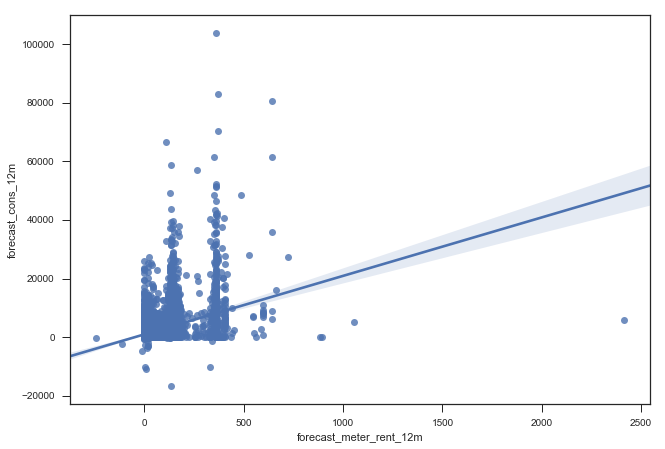

In [90]:
rg=sns.regplot(train_with_prices.forecast_meter_rent_12m,train_with_prices.forecast_cons_12m)

In [91]:
rg=sns.regplot()

TypeError: regplot() missing 2 required positional arguments: 'x' and 'y'

In [ ]:
kde_by_churn2('avg_prc','avg_prc disctribution',train_with_prices)

In [ ]:
kde_by_churn2('avg_prc_fx','',train_with_prices)

In [ ]:
kde_by_churn2('mean_price1','mean_price1 disctirbution',train_with_prices)

In [ ]:
kde_by_churn2('mean_price2','mean_price2 disctirbution',train_with_prices)

In [ ]:
kde_by_churn2('mean_price3','mean_price3 disctirbution',train_with_prices)

In [ ]:
kde_by_churn2('mean_price_fix1','mean_price_fix1 disctirbution',train_with_prices)

In [ ]:
kde_by_churn2('mean_price_fix2','mean_price_fix2 disctirbution',train_with_prices)

In [ ]:
kde_by_churn2('mean_price_fix3','mean_price_fix3 disctirbution',train_with_prices)

In [ ]:
kde_by_churn2('imp_cons','imp_cons  disctirbution',train_with_prices)

In [ ]:
kde_by_churn2('cons_gas_12m','cons_gas_12m  disctirbution',train_with_prices)

In [ ]:
kde_by_churn2('cons_last_month','cons_last_month  disctirbution',train_with_prices)

In [ ]:
kde_by_churn2('pow_max','pow_max  disctirbution',train_with_prices)

In [ ]:
rg=sns.regplot(train_with_prices.avg_prc,train_with_prices.margin_gross_pow_ele)

In [ ]:
rg=sns.regplot(train_with_prices.avg_prc,train_with_prices.margin_gross_pow_ele)

In [ ]:
rg=sns.regplot(train_with_prices.avg_prc,train_with_prices.net_margin)

### Count top N margin companies

In [ ]:
def calculate_share_in_total_portfolio(var_name):
        mrgn=pd.DataFrame()
        mrgn=train_with_prices.loc[:, ['id',var_name,'churn']].sort_values(by=[var_name],ascending=False)
        mrgn['cumsum']=mrgn[var_name].cumsum()
        mrgn['total']=mrgn[var_name].sum()
        mrgn['share_in_'+var_name]=mrgn['cumsum']/mrgn['total']*100

        print('30%'+var_name+' is done by ',mrgn[mrgn['share_in_'+var_name]<30].id.count()/mrgn.id.count()*100,"% of "+var_name+' companies')
        print('50%'+var_name+' is done by ',mrgn[mrgn['share_in_'+var_name]<50].id.count()/mrgn.id.count()*100,"% of "+var_name+' companies')
        print('80%'+var_name+' is done by ',mrgn[mrgn['share_in_'+var_name]<80].id.count()/mrgn.id.count()*100,"% of "+var_name+' companies')
        print('90%'+var_name+' is done by ',mrgn[mrgn['share_in_'+var_name]<90].id.count()/mrgn.id.count()*100,"% of "+var_name+' companies')

In [ ]:
calculate_share_in_total_portfolio('net_margin')

In [ ]:
calculate_share_in_total_portfolio('cons_gas_12m')

In [ ]:
calculate_share_in_total_portfolio('cons_12m')

In [ ]:
calculate_share_in_total_portfolio('imp_cons')

In [ ]:
correlations = train_with_prices.corr()['churn'].sort_values()
# Отображение
print('The highest positive correlation: \n', correlations.tail(15))
print('\nThe highest negative correlation: \n', correlations.head(15))

### Generate polynomial features

In [ ]:
train_with_prices1=train_with_prices.copy()
test_with_prices1=test_with_prices.copy()

In [ ]:
poly_features_list=['margin_gross_pow_ele','margin_net_pow_ele','num_change_price3']
# создадим новый датафрейм для полиномиальных признаков
poly_features = train_with_prices1[poly_features_list]
poly_features_test = test_with_prices1[poly_features_list]

poly_target = train_with_prices1['churn']

# обработаем отуствующие данные
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

##poly_target = train_with_prices['churn']
##poly_features = poly_features.drop('churn', axis=1)

poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Создадим полиномиальный объект степени 3
poly_transformer = PolynomialFeatures(degree = 4)

# Тренировка полиномиальных признаков
poly_transformer.fit(poly_features)

# Трансформация признаков
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Format of polynomial features: ', poly_features.shape)

In [ ]:
##poly_transformer.get_feature_names()

In [ ]:
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(poly_features_list))
##poly_features['churn'] = poly_target


In [ ]:
# add poly features to the main dataset
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(poly_features_list))

# merge train data
poly_features['id'] = train_with_prices1['id']
train_with_prices_poly = train_with_prices1.merge(poly_features, on = 'id', how = 'left')

# merge test data
poly_features_test['id'] = test_with_prices1['id']
test_with_prices_poly = test_with_prices1.merge(poly_features_test, on = 'id', how = 'left')

# align_dataframes
train_with_prices_poly, test_with_prices_poly = train_with_prices_poly.align(test_with_prices_poly, join = 'inner', axis = 1)

# check the format
print('Train with polinomial features: ', train_with_prices_poly.shape)
print('Test with polinomial features: ', test_with_prices_poly.shape)

In [ ]:
##poly_transformer.get_feature_names(poly_features_list)

In [ ]:
print("train_with_prices_poly",train_with_prices_poly.shape)
print("test_with_prices_poly",test_with_prices_poly.shape)

In [ ]:
cat_features=['channel_sales','has_gas','origin_up']
ordinal_data=['nb_prod_act']
dates=['date_activ','date_end','date_first_activ','date_modif_prod','date_modif_prod','date_renewal']
num_features=['cons_gas_12m','cons_12m','cons_last_month','forecast_base_bill_ele','forecast_base_bill_year','forecast_bill_12m' ,'forecast_cons','forecast_cons_12m','forecast_cons_year','forecast_discount_energy','forecast_meter_rent_12m','forecast_price_energy_p1','forecast_price_energy_p2','forecast_price_pow_p1','imp_cons','margin_gross_pow_ele','margin_net_pow_ele','net_margin' ,'num_years_antig' ,'pow_max']
no_use=['activity_new','campaign_disc_ele',]
new_features=['days_since_activation','days_to_contract_end','days_since_first_contract','days_since_last_prod_mod','days_to_renewal']
target=['churn']
missingmore50=['date_first_activ','forecast_base_bill_ele','forecast_base_bill_year','forecast_bill_12m','forecast_cons']
poly_features=poly_transformer.get_feature_names(poly_features_list)
inf=['avg_qty1','avg_qty2','avg_qty3']


In [ ]:
train_with_prices_poly.head()

In [ ]:
train_labels=train_with_prices_poly.churn

In [ ]:
train_with_prices.mean_price3

In [ ]:
from sklearn import mixture
import pandas as pd

df_prices=pd.DataFrame()

df_prices=train_with_prices[['id','mean_price1','churn']]
df_prices1=df_prices.mean_price1..reset_index()
##df_prices1.mean_price1=np.log(df_prices1.mean_price1)

x=df_prices1.fillna(0)

em = mixture.GMM(n_components=3)

em.fit(x) 

df_prices['CLUSTER'] = em.predict(x)

In [ ]:
x.head()
x.tail()
df_prices.CLUSTER.value_counts()

In [ ]:
x1=df_prices[df_prices.CLUSTER==1]
x1.head()

In [ ]:
kde_by_churn2('mean_price1','mean_price1',x1)

In [ ]:
x1.mean_price1.hist()

In [ ]:
ppopopo

In [ ]:
import gc
gc.collect()

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix,roc_curve,auc
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index,model):
    y_predictproba = model.predict_proba(X.iloc[index])[:,1]
    y_predict = model.predict(X.iloc[index])
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predictproba)
    auc_score = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y.iloc[index], y_predict)
    
    return fpr, tpr, auc_score,precision,recall

def show_feature_importances(model, features):
    
    plt.figure(figsize = (12, 8))
    
    # Создадаим датафрейм фич и их важностей и отсортируем его 
    results = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    results = results.sort_values('importance', ascending = False)
    # Отображение
    print(results.head(10))
    print('\n Features with importance > 0.01 = ', np.sum(results['importance'] > 0.01))
    
    # График
    results.head(20).plot(x = 'feature', y = 'importance', kind = 'barh',
                     color = 'red', edgecolor = 'k', title = 'Feature Importances');
    return results

In [ ]:
correlations = train_with_prices_poly.corr()['churn'].sort_values()
# Отображение
print('The highest positive correlation: \n', correlations.tail(15))
print('\nThe highest negative correlation: \n', correlations.head(15))

### Different set of features preparation

In [ ]:
cat_features=['channel_sales','has_gas','origin_up']
ordinal_data=['nb_prod_act']
dates=['date_activ','date_end','date_first_activ','date_modif_prod','date_modif_prod','date_renewal']
num_features=['cons_gas_12m','cons_12m','cons_last_month','forecast_base_bill_ele','forecast_base_bill_year','forecast_bill_12m' ,'forecast_cons','forecast_cons_12m','forecast_cons_year','forecast_discount_energy','forecast_meter_rent_12m','forecast_price_energy_p1','forecast_price_energy_p2','forecast_price_pow_p1','imp_cons','margin_gross_pow_ele','margin_net_pow_ele','net_margin' ,'num_years_antig' ,'pow_max']
no_use=['activity_new','campaign_disc_ele','days_since_activation']
new_features=['days_since_activation','days_to_contract_end','days_since_first_contract','days_since_last_prod_mod','days_to_renewal']
target=['churn']
missingmore50=['date_first_activ','forecast_base_bill_ele','forecast_base_bill_year','forecast_bill_12m','forecast_cons']
poly_features=poly_transformer.get_feature_names(poly_features_list)
inf=['avg_qty1','avg_qty2','avg_qty3']

### original_features

In [ ]:
float64=list(train.loc[:, train.dtypes == np.float64].columns)
uint8=list(train.loc[:, train.dtypes == np.uint8].columns)
int64=list(train.loc[:, train.dtypes == np.int64].columns)

### prices features

In [ ]:
float64_prices=list(train_with_prices.loc[:, train_with_prices.dtypes == np.float64].columns)
uint8_prices=list(train_with_prices.loc[:, train_with_prices.dtypes== np.uint8].columns)
int64_prices=list(train_with_prices.loc[:, train_with_prices.dtypes== np.int64].columns)

### poly features

In [ ]:
float64_poly=list(train_with_prices_poly.loc[:, train_with_prices_poly.dtypes == np.float64].columns)
uint8_poly=list(train_with_prices_poly.loc[:, train_with_prices_poly.dtypes == np.uint8].columns)
int64_poly=list(train_with_prices_poly.loc[:, train_with_prices_poly.dtypes == np.int64].columns)

In [ ]:
numeric_features=float64+uint8+int64
numeric_features_prices=float64_prices+uint8_prices+int64_prices
numeric_features_poly=float64_poly+uint8_poly+int64_poly

In [ ]:
##prices
def define_set_of_features(yourset):
    no_use_all=missingmore50+no_use+dates+target+inf
    features_for_modeling=[x for x in yourset if x not in no_use_all]
    return features_for_modeling

In [ ]:
define_set_of_features(train_with_prices)

In [ ]:
##X = train[define_set_of_features(numeric_features)]
##X=X.fillna(value=X.mean())
##y = train.churn

In [ ]:
X = train_with_prices[define_set_of_features(numeric_features_prices)]
X=X.fillna(value=X.mean())
y = train_with_prices.churn

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
##X = train_with_prices_poly[define_set_of_features(numeric_features_poly)]
##X=X.fillna(value=X.mean())
##y = train_with_prices_poly.churn

## Directly undersampling the data

In [ ]:
def get_undersampled_data_set(df):
    df1=df.copy()
    no_churn = len(df1[df1['churn'] == 1])
    non_churn_indices = df1[df1.churn == 0].index
    random_indices = np.random.choice(non_churn_indices,no_churn, replace=False)
    churn_indices = df1[df1.churn == 1].index
    under_sample_indices = np.concatenate([churn_indices,random_indices])

    df2=df1.loc[under_sample_indices]
    
    return df2

In [ ]:
undersampled_data=get_undersampled_data_set(train_with_prices)

In [ ]:
undersampled_data.shape

#### TESTING BLOCK BEGIN

In [ ]:
## take the subset with prices features- all data
Tr = train_with_prices[define_set_of_features(numeric_features_prices)]
Tr=Tr.fillna(value=Tr.mean())
T = train_with_prices.churn
## split data into train and test(to test that model generalizes on unbalanced subset)
X_train, X_test, y_train, y_test = train_test_split(
Tr,T, test_size=0.2, random_state=42)

## add target before undersampling
X_train["churn"]=y_train

## undersample negative class to positive class amount
X = get_undersampled_data_set(X_train)
## fill negative values to mean value
X =X.fillna(value=X.mean())
## create target variable
y= X.churn
## take subset with numerc features only
X =X[define_set_of_features(numeric_features_prices)]


In [ ]:
## check the shapes os each dataframe
print(X_train.shape)
print(y_train.shape)
print(X_train.churn.sum()*2)
print(X_test.shape)
print(y_test.shape)

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
print(Tr.shape)
print(T.shape)

#### TESTING BLOCK END

In [ ]:
X = undersampled_data[define_set_of_features(numeric_features_prices)]
X =X.fillna(value=X.mean())
y= undersampled_data.churn

In [ ]:
print (X.shape)
print (y.shape)

### Logistic regression

In [ ]:
##from sklearn.preprocessing import scale
X1=X.copy()
y1=y.copy()
lr = LogisticRegression()

print (X1.shape)
print (y1.shape)

In [ ]:
sub_preds = np.zeros(test.shape[0])
sub_preds.shape

## create final test subset for for final test score
testf=test_with_prices[define_set_of_features(numeric_features_prices)]
testf=testf.fillna(value=testf.mean())

## create subset for out of samples to prove that model generalizes after on unbalanced after undersampling
##testf_test=X_test[define_set_of_features(numeric_features_prices)]
##testf_test=testf_test.fillna(value=testf_test.mean())

In [ ]:
testf.shape
sub_preds.shape

In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['train_score', 'test_score'])
fprs, tprs, scores = [], [], []
sub_preds = np.zeros(test.shape[0])
##sub_preds_test = np.zeros(testf_test.shape[0])
threshold = 0.5

for (tr, ts), i in zip(cv.split(X1, y1), range(5)):
    
    print('tr size='+str(len(tr))+"|num churn cases="+str(y.iloc[tr].sum()))
    print('ts size='+str(len(ts))+"|num churn cases="+str(y.iloc[ts].sum()))
  
    lr.fit(X1.iloc[tr], y1.iloc[tr])
    _, _, auc_score_train,precision_tr,recall_tr = compute_roc_auc(tr,lr)
    fpr, tpr, auc_score,precision_ts,recall_ts = compute_roc_auc(ts,lr)
    
    ##predict = rf.predict(X.iloc[ts])
    ##proba = lr.predict_proba(X1.iloc[ts])
    
    predicted_proba = lr.predict_proba(X1.iloc[ts])
    predict = (predicted_proba [:,1] >= threshold).astype('int')
    
    sub_preds += lr.predict_proba(testf)[:, 1] /cv.n_splits
    ##sub_preds_test += lr.predict_proba(testf_test)[:, 1] /cv.n_splits
   

    print ("AUC train",auc_score_train,"AUC test:",auc_score)
    print (classification_report(predict, y1.iloc[ts]))
    
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [ ]:
sub_preds.shape

In [ ]:
threshold = 0.5
submission = test[['id']]
submission['Churn_probability'] = sub_preds
submission['Churn_prediction']=(sub_preds >= threshold).astype('int')

submission=submission.sort_values(by=['Churn_probability'],ascending=False)
submission.head()

submission['Churn_prediction'].sum()

submission.to_csv('logistic_regression_18-10-2018.csv', index = False)


In [ ]:
##fpr, tpr, thresholds = roc_curve(y_test, sub_preds_test)
##auc_score = auc(fpr, tpr)
##auc_score

In [ ]:
y_test.shape

### RANDOM FOREST 

In [ ]:
X.head()

In [ ]:
rf = RandomForestClassifier(
class_weight='balanced'
)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=5,
    ##min_impurity_decrease=0.0,
    ##min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    ##class_weight='balanced'
)

In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['train_score', 'test_score'])
fprs, tprs, scores = [], [], []
##sub_preds_test = np.zeros(testf_test.shape[0])
sub_preds = np.zeros(test.shape[0])
threshold = 0.5

for (tr, ts), i in zip(cv.split(X, y), range(5)):
    
    print('tr size='+str(len(tr))+"|num churn cases="+str(y.iloc[tr].sum()))
    print('ts size='+str(len(ts))+"|num churn cases="+str(y.iloc[ts].sum()))
  
    rf.fit(X.iloc[tr], y.iloc[tr])
    _, _, auc_score_train,precision_tr,recall_tr = compute_roc_auc(tr,rf)
    fpr, tpr, auc_score,precision_ts,recall_ts = compute_roc_auc(ts,rf)
    
    ##predict = rf.predict(X.iloc[ts])
    proba = rf.predict_proba(X.iloc[ts])
    
    predicted_proba = rf.predict_proba(X.iloc[ts])
    predict = (predicted_proba [:,1] >= threshold).astype('int')

    print ("AUC train",auc_score_train,"AUC test:",auc_score)
    print (classification_report(predict, y.iloc[ts]))
    
    sub_preds += rf.predict_proba(testf)[:, 1] /cv.n_splits
    ##sub_preds_test += rf.predict_proba(testf_test)[:, 1] /cv.n_splits
    
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [ ]:
##fpr, tpr, thresholds = roc_curve(y_test, sub_preds_test)
##auc_score = auc(fpr, tpr)
##auc_score

In [ ]:
threshold = 0.5
submission = test[['id']]
submission['Churn_prediction']=(sub_preds >= threshold).astype('int')
submission['Churn_probability'] = sub_preds

submission=submission.sort_values(by=['Churn_probability'],ascending=False)
submission.head()


submission.to_csv('random_forest_18-10-2018_fin.csv', index = False)
submission['Churn_prediction'].sum()

In [ ]:
show_feature_importances(rf,define_set_of_features(numeric_features_prices))

#### WORKING ON THIS BLOCK TO IMPROVE THE MODEL 16.10.2018 start

Use small max_bin
Use small num_leaves
Use min_data_in_leaf and min_sum_hessian_in_leaf
Use bagging by set bagging_fraction and bagging_freq
Use feature sub-sampling by set feature_fraction
Use bigger training data
Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
Try max_depth to avoid growing deep tree

In [ ]:
gb = LGBMClassifier(
             boosting_type='gbdt',
             lambda_l1= 0,
             feature_fraction=0.5,
             lambda_l2=0.1, #1
             min_data_in_leaf=30, 
             num_leaves=3, #100,30 ##default = 255
             reg_alpha=0.1,
             max_bin=50,
             ##scale_pos_weight=12,
             min_data_in_bin=3   ##default=3
             ##bagging_fraction= ##
)

In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['train_score', 'test_score'])
fprs, tprs, scores = [], [], []
##sub_preds_test = np.zeros(testf_test.shape[0])
sub_preds = np.zeros(test.shape[0])
threshold = 0.5

for (tr, ts), i in zip(cv.split(X, y), range(5)):
    
    print('tr size='+str(len(tr))+"|num churn cases="+str(y.iloc[tr].sum()))
    print('ts size='+str(len(ts))+"|num churn cases="+str(y.iloc[ts].sum()))
    gb.fit(X.iloc[tr], y.iloc[tr])
    _, _, auc_score_train,precision_tr,recall_tr = compute_roc_auc(tr,gb)
    fpr, tpr, auc_score,precision_ts,recall_ts = compute_roc_auc(ts,gb)
    predict = gb.predict(X.iloc[ts])
    
    
    proba = gb.predict_proba(X.iloc[tr])
    print ("AUC train",auc_score_train,"AUC test:",auc_score)
    print (classification_report(predict, y.iloc[ts]))
    
    sub_preds += gb.predict_proba(testf)[:, 1] /cv.n_splits
    ##sub_preds_test += gb.predict_proba(testf_test)[:, 1] /cv.n_splits
    
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    
plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [ ]:
show_feature_importances(gb,define_set_of_features(numeric_features_prices))

{'lambda_l1': 0, 'lambda_l2': 1, 'min_data_in_leaf': 30, 'num_leaves': 127, 'reg_alpha': 0.1} 0.908921471173

In [ ]:
##fpr, tpr, thresholds = roc_curve(y_test, sub_preds_test)
##auc_score = auc(fpr, tpr)
##auc_score

In [ ]:
threshold = 0.5
submission = test[['id']]
submission['Churn_probability'] = sub_preds
submission['Churn_prediction']=(sub_preds >= threshold).astype('int')

submission=submission.sort_values(by=['Churn_probability'],ascending=False)
submission.head()

submission['Churn_prediction'].sum()

submission.to_csv('light_gbm_18-10-2018.csv', index = False)

submission['Churn_prediction'].sum()